In [1]:
%matplotlib inline

import os
import sys
import copy
import time
import numpy as np
#np.seterr(over='ignore')
import scipy as sp

# filtering Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
from hdmclouds import *
from utils import *
from graph import *
from preprocessing import *
from gmr import *

from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider
import aplpy
import matplotlib
import matplotlib.pyplot as plt; plt.show()
matplotlib.rcParams.update({'font.size': 13})

from pycupid import *

save_path = "/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/HDMC-v1/figures/"

/Users/martin/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
@numba.jit(nopython=True)
def u_eval_full(c, sig, xc, yc, xe, ye, support=5):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            x = np.array( [xe[i]-xc[j], ye[i]-yc[j]] )
            tmp = np.dot(x, np.dot(np.linalg.inv(sig[j]), x))
            ret[i] += c[j]*exp(-tmp)
    return ret

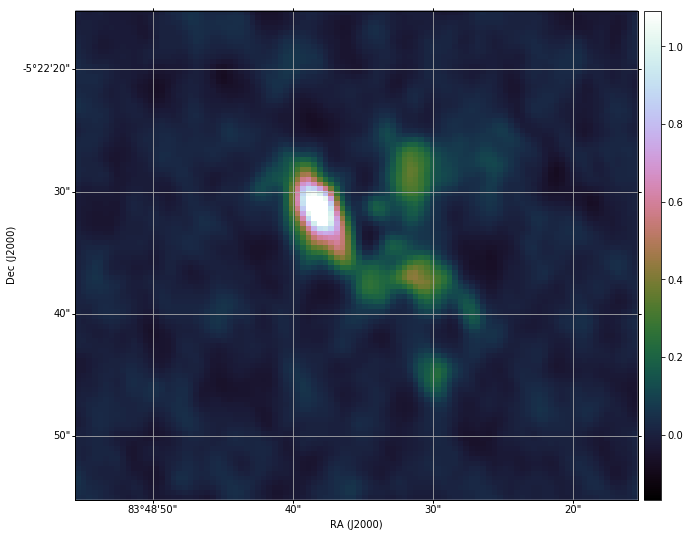

In [3]:
fits_path = '../data/images/Orion.cont.image.fits'

data, wcs, hdu = load_data(fits_path)
base_level = estimate_rms(data)
image_plot(data, wcs=wcs)

In [4]:
hdmc = HDMClouds(data, back_level=0.089, wcs=wcs, verbose=False, n_center=200)

/Users/martin/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
../lib/points_generation.py:202: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum()
../lib/points_generation.py:191: RuntimeWarning: invalid value encountered in less
  sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]
../lib/points_generation.py:191: RuntimeWarning: invalid value encountered in greater
  sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]


No more points can be selected: Only 35 point from the 40 were selected.


In [6]:
# mask of significant emission pixels
mask = hdmc.mask

# initial w
w = (data[mask]).astype(np.float64)

# pixels positions
_x = np.linspace(0., 1., data.shape[0]+1, endpoint=True)
_y = np.linspace(0., 1., data.shape[1]+1, endpoint=True)
xpos = np.asarray( [(_x[i]+_x[i+1])/2 for i in range(len(_x)-1)] )
ypos = np.asarray( [(_y[i]+_y[i+1])/2 for i in range(len(_y)-1)] )
X,Y  = np.meshgrid(xpos, ypos, indexing='ij')
xgrid = X.ravel()
ygrid = Y.ravel()
xc = X[mask]
yc = Y[mask]
mu = np.vstack([xc,yc]).T

# sigma
pix_lenght = min(1./data.shape[0], 1./data.shape[1])
k = 0.25
sig = (pix_lenght/(2.*k))*np.ones(w.shape[0])

# P-finer grid
P = 5
_x = np.linspace(0., 1., P*data.shape[0]+1, endpoint=True)
_y = np.linspace(0., 1., P*data.shape[1]+1, endpoint=True)
xpos = np.asarray( [(_x[i]+_x[i+1])/2 for i in range(len(_x)-1)] )
ypos = np.asarray( [(_y[i]+_y[i+1])/2 for i in range(len(_y)-1)] )
X,Y  = np.meshgrid(xpos, ypos, indexing='ij')
xgrid2 = X.ravel()
ygrid2 = Y.ravel()

### Visualizing the initial guess before agglomeration

In [7]:
u = u_eval(w, sig, xc, yc, xgrid, ygrid)
w1 = w * (data.max()/u.max())
u = u_eval(w1, sig, xc, yc, xgrid, ygrid)
u = u.reshape(data.shape)

u2 = u_eval(w, sig, xc, yc, xgrid2, ygrid2)
w2 = w * (data.max()/u2.max())
u2 = u_eval(w2, sig, xc, yc, xgrid2, ygrid2)
u2 = u2.reshape( (P*data.shape[0],P*data.shape[1]) )

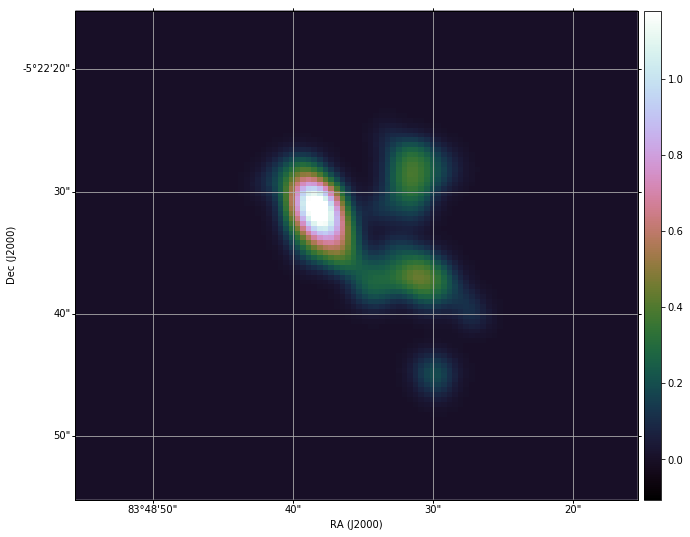

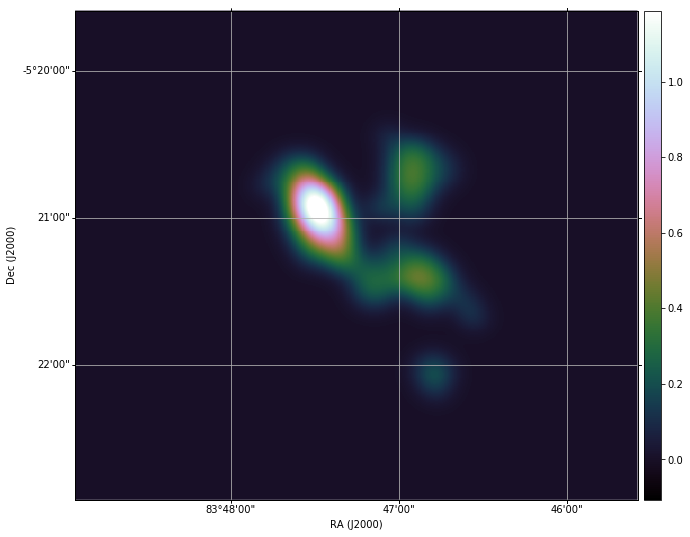

In [13]:
image_plot(u, wcs=wcs)
image_plot(u2, wcs=wcs)

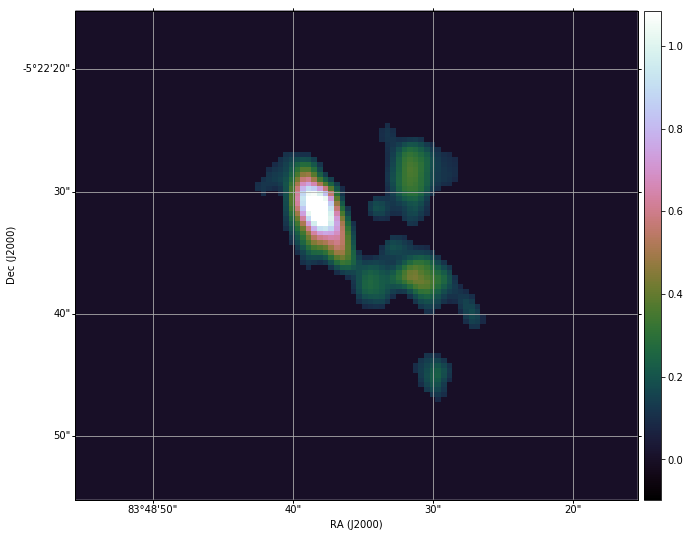

In [14]:
_data = np.copy(data)
_data[~hdmc.mask] = 0
image_plot(_data, wcs=wcs)

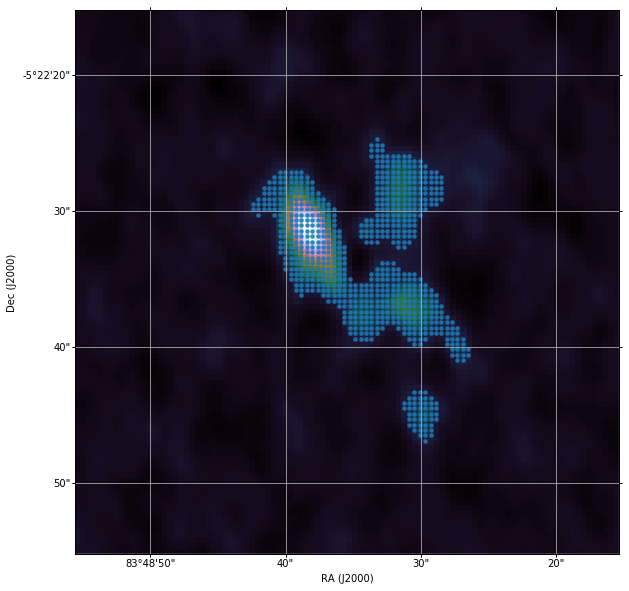

In [15]:
points_plot(data, points=mu, wcs=wcs)

### Visualizing initial guess after agglomeration

In [17]:
# COMPARACION DE TIEMPOS
t0 = time.time()
out = gaussian_reduction(w, mu, sig, 200, verbose=False)
print("Elapsed time:", time.time()-t0)

t0 = time.time()
w_red,mu_red,sig_red = mixture_reduction(w, mu, sig, 200, verbose=False)
print("Elapsed time:", time.time()-t0)

Elapsed time: 183.40735793113708


In [16]:
t0 = time.time()
w_red,mu_red,sig_red = mixture_reduction(w1, mu, sig, 200, verbose=False)
print("Elapsed time:", time.time()-t0)

Elapsed time: 104.4178147315979


__NOTA__: Sacar el promedio de los valores de la diagonal de $\Sigma$ es exáctamente igual a sacar el promedio de sus _eigenvalues_ (empíricamente). 

In [14]:
xc_red = mu_red[:,0]
yc_red = mu_red[:,1]

sig_red1 = np.asarray( [np.linalg.det(cov)**(1./4) for cov in sig_red] )
sig_red2 = np.asarray( [np.mean((np.linalg.eig(cov)[0]))**(1./2) for cov in sig_red] )

In [15]:
print("Initial sigma:",sig[0],"\n")

print("min and max sigma with determinant truncation:")
print(sig_red1.min()) 
print(sig_red1.max())

print("\nmin and max sigma with mean eigenvalue truncation:")
print(sig_red2.min()) 
print(sig_red2.max())


Initial sigma: 0.02 

min and max sigma with determinant truncation:
0.02
0.021680467550844167

min and max sigma with mean eigenvalue truncation:
0.02
0.021729901848598816


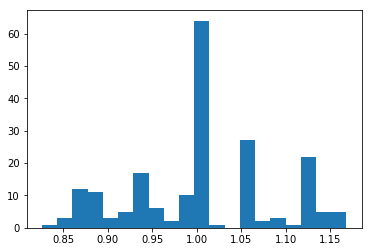

In [20]:
exc_arr = np.asarray( [np.linalg.eig(cov)[0][0]/np.linalg.eig(cov)[0][1] for cov in sig_red] )
plt.hist(exc_arr, bins=20)
plt.show()

In [67]:
%timeit -n 5 u_eval_full(w_red, sig_red, xc_red, yc_red, xgrid, ygrid)

3.42 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [68]:
%timeit -n 5 u_eval(w_red, sig_red1, xc_red, yc_red, xgrid, ygrid)

33.8 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


#### Original

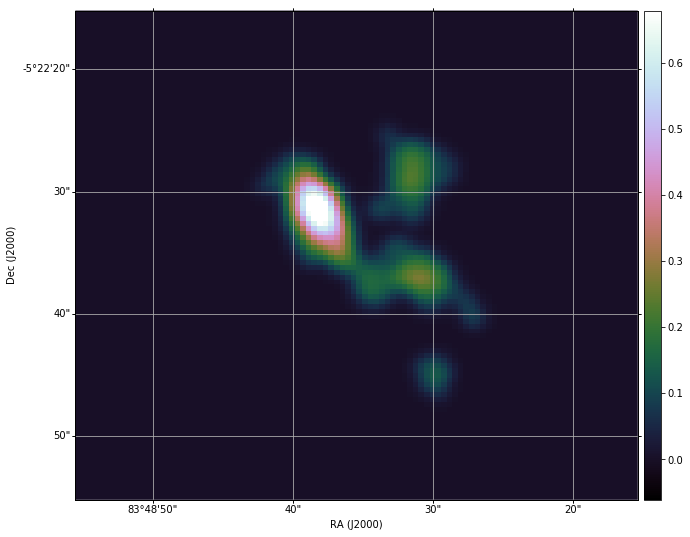

In [69]:
u0 = u_eval_full(w_red, sig_red, xc_red, yc_red, xgrid, ygrid)
u0 = u0.reshape(data.shape)
image_plot(u0, wcs=wcs)

#### Determinant truncation

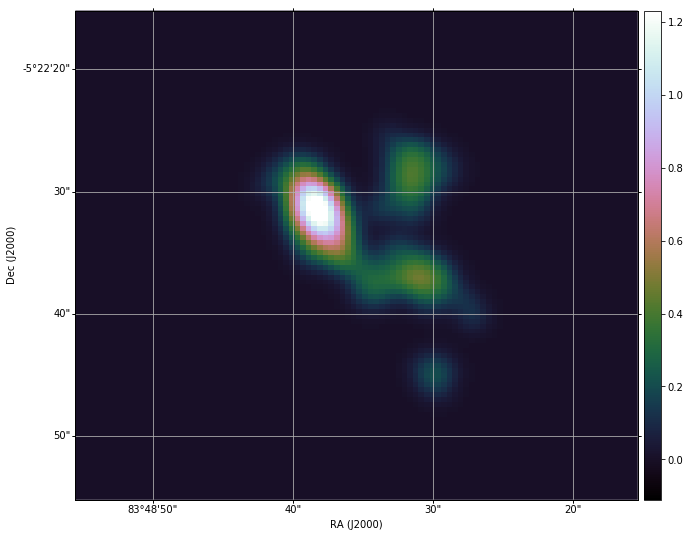

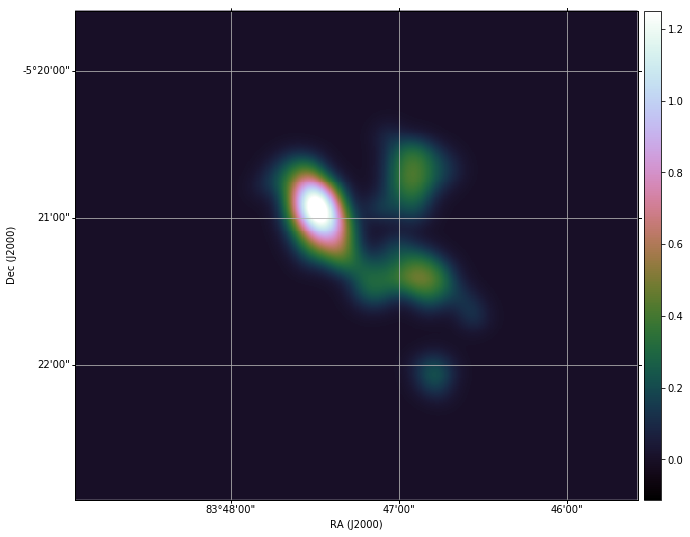

In [79]:
u1 = u_eval(w_red, sig_red1, xc_red, yc_red, xgrid, ygrid)
u1 = u1.reshape(data.shape)
image_plot(u1, wcs=wcs)


_u1 = u_eval(w_red, sig_red1, xc_red, yc_red, xgrid2, ygrid2)
_u1 = _u1.reshape( (P*data.shape[0],P*data.shape[1]) )
image_plot(_u1, wcs=wcs)

#### Mean eigenvalue

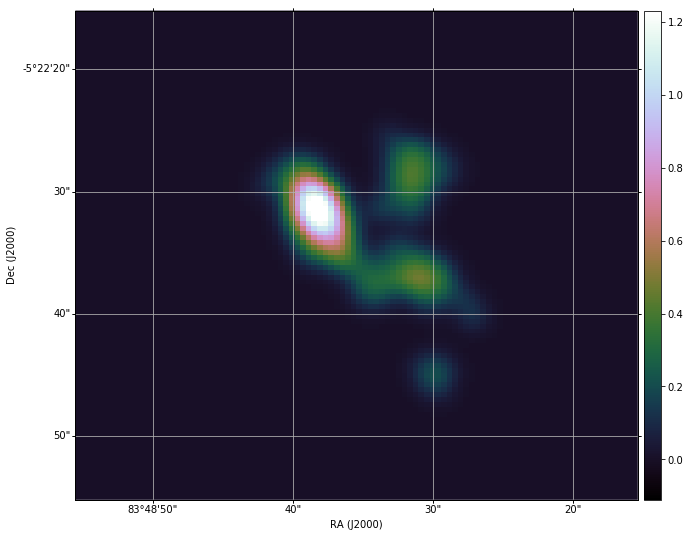

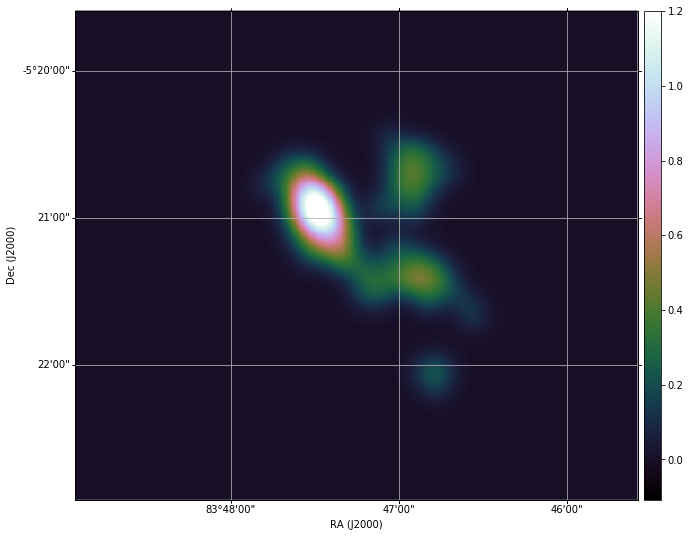

In [80]:
u2 = u_eval(w_red, sig_red2, xc_red, yc_red, xgrid, ygrid)
u2 = u2.reshape(data.shape)
image_plot(u2, wcs=wcs)

_u2 = u_eval(w_red, sig_red2, xc_red, yc_red, xgrid2, ygrid2)
_u2 = _u2.reshape( (P*data.shape[0],P*data.shape[1]) )
image_plot(_u2, wcs=wcs)

## Comparison for different values of `k`

In [14]:
def initial_guess(data, mask, k=1., n_center=200, isomorphic=False):
    # initial w
    w = (data[mask]).astype(np.float64)

    # pixels positions
    _x = np.linspace(0., 1., data.shape[0]+1, endpoint=True)
    _y = np.linspace(0., 1., data.shape[1]+1, endpoint=True)
    xpos = np.asarray( [(_x[i]+_x[i+1])/2 for i in range(len(_x)-1)] )
    ypos = np.asarray( [(_y[i]+_y[i+1])/2 for i in range(len(_y)-1)] )
    X,Y  = np.meshgrid(xpos, ypos, indexing='ij')
    xgrid = X.ravel()
    ygrid = Y.ravel()
    xc = X[mask]
    yc = Y[mask]
    mu = np.vstack([xc,yc]).T

    # sigma
    pix_lenght = min(1./data.shape[0], 1./data.shape[1])
    sig = (pix_lenght/(2.*k))*np.ones(w.shape[0])
    
    # agglomeration
    w_red,mu_red,sig_red = mixture_reduction(w, mu, sig, n_center, isomorphic=isomorphic, verbose=False)
    
    # conversions and truncations
    w_red = np.asarray(w_red)
    mu_red = np.asarray(mu_red)
    xc_red = mu_red[:,0]
    yc_red = mu_red[:,1]

    sig_red0 = np.asarray(sig_red)
    if not isomorphic:
        sig_red1 = np.asarray( [np.linalg.det(cov)**(1./4) for cov in sig_red] )
        sig_red2 = np.asarray( [np.max(np.diag(cov))**(1./2) for cov in sig_red] )
        sig_red3 = np.asarray( [np.mean(np.diag(cov))**(1./2) for cov in sig_red] )
    
    # showing some data
    print("Initial sigma:",sig[0],"\n")
    
    if isomorphic:
        print("min and max sigma with isomorphic merge:")
        print(sig_red0.min()) 
        print(sig_red0.max())  
    else:
        print("min and max sigma with determinant truncation:")
        print(sig_red1.min()) 
        print(sig_red1.max())

        print("\nmin and max sigma with max truncation:")
        print(sig_red2.min()) 
        print(sig_red2.max())

        print("\nmin and max sigma with mean truncation")
        print(sig_red3.min()) 
        print(sig_red3.max())

    u0 = u_eval_full(w_red, sig_red0, xc_red, yc_red, xgrid, ygrid)
    u0 = u0.reshape(data.shape)
    image_plot(u0, wcs=wcs, title="No truncation")
    
    if not isomorphic:
        u1 = u_eval(w_red, sig_red1, xc_red, yc_red, xgrid, ygrid)
        u1 = u1.reshape(data.shape)
        image_plot(u1, wcs=wcs, title="Determinant truncation")

        u2 = u_eval(w_red, sig_red2, xc_red, yc_red, xgrid, ygrid)
        u2 = u2.reshape(data.shape)
        image_plot(u2, wcs=wcs, title="Max truncation")

        u3 = u_eval(w_red, sig_red3, xc_red, yc_red, xgrid, ygrid)
        u3 = u3.reshape(data.shape)
        image_plot(u3, wcs=wcs, title="Mean truncation")
    
    # final centers points
    points_plot(data, points=mu_red, wcs=wcs)


##########################
# k = 0.1
##########################
Initial sigma: 0.049999999999999996 

min and max sigma with determinant truncation:
0.05000000000000001
0.05072635672027981

min and max sigma with max truncation:
0.049999999999999996
0.051197892899913035

min and max sigma with mean truncation
0.049999999999999996
0.05072700496192099


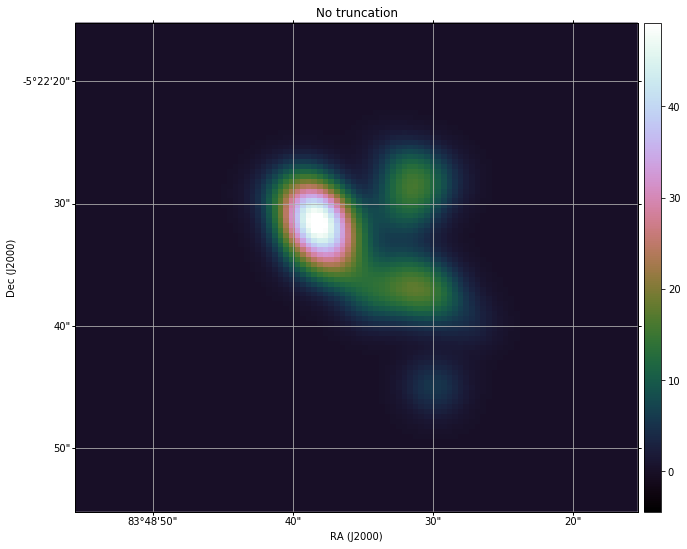

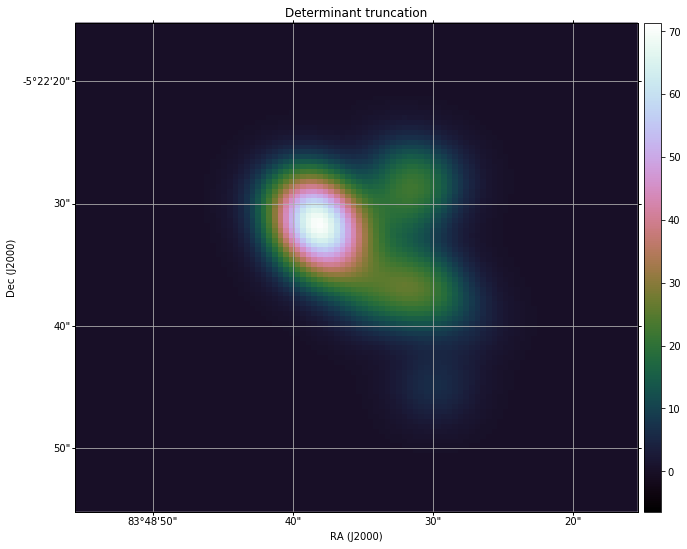

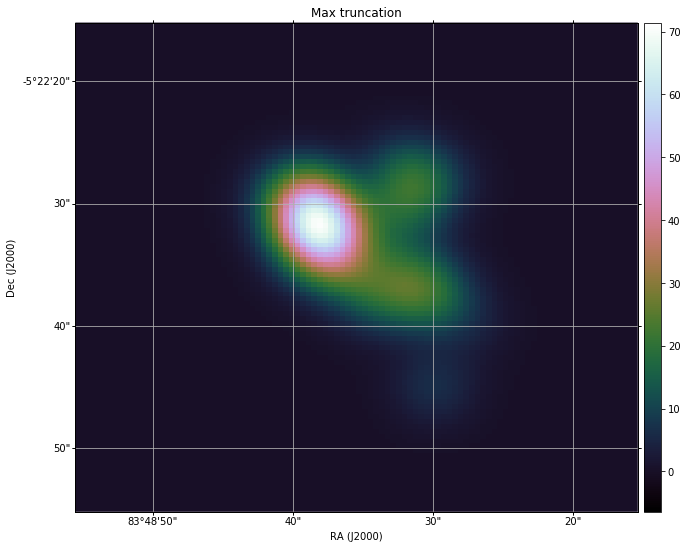

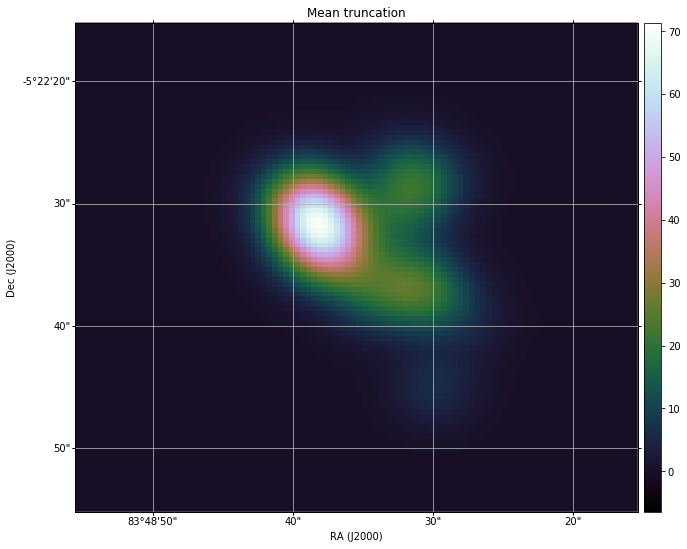

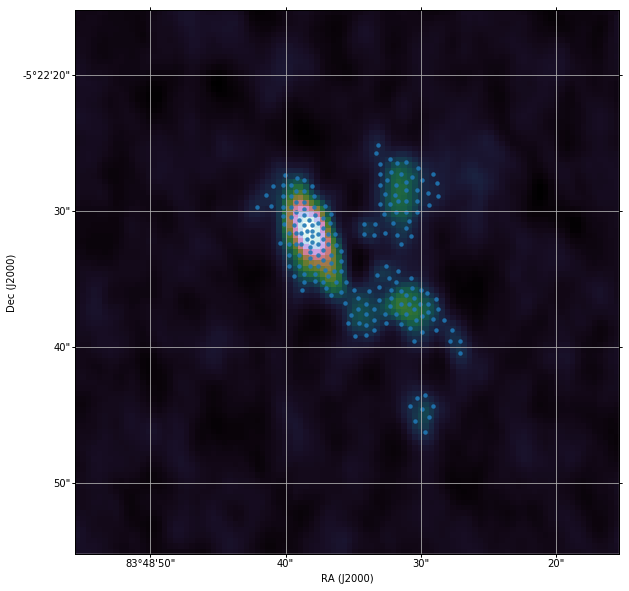


##########################
# k = 0.25
##########################
Initial sigma: 0.02 

min and max sigma with determinant truncation:
0.02
0.02174560394930044

min and max sigma with max truncation:
0.02
0.022643665143444736

min and max sigma with mean truncation
0.02
0.02175382799432681


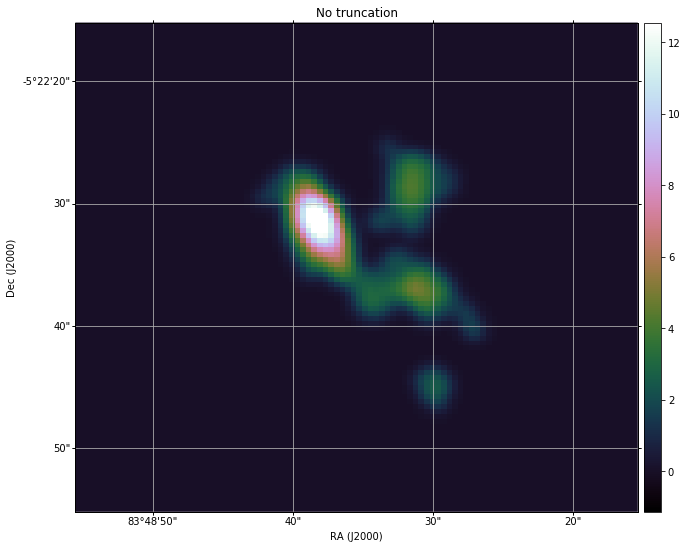

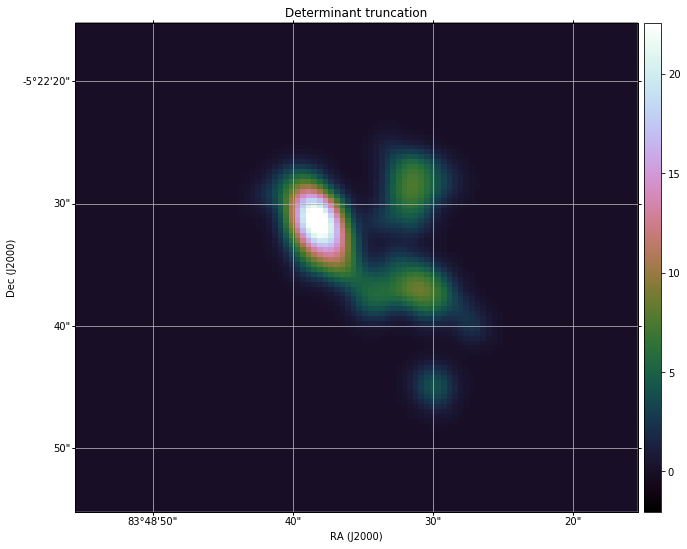

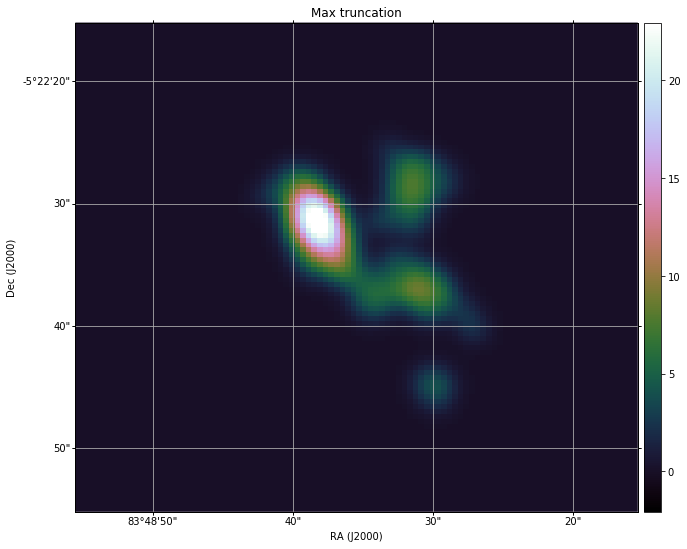

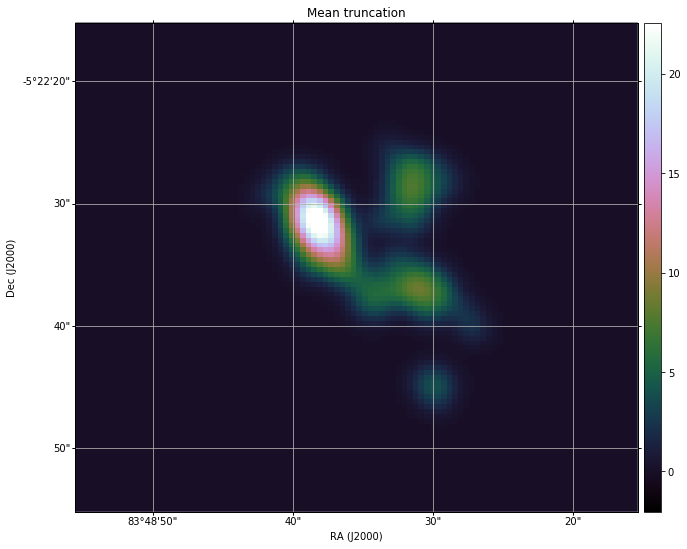

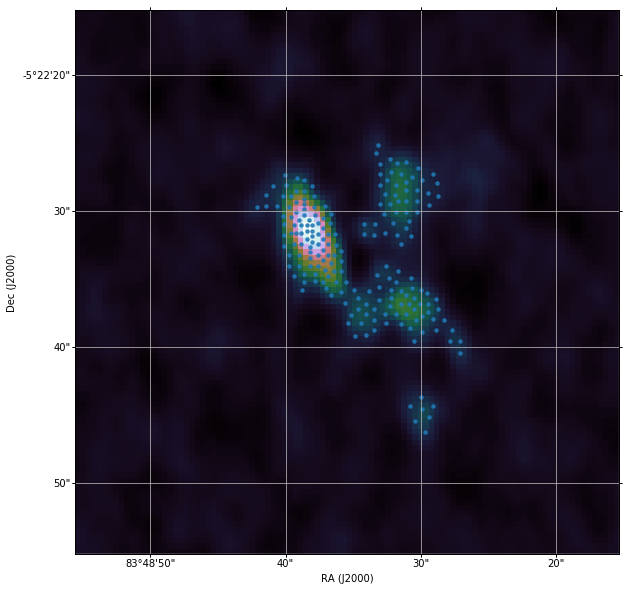


##########################
# k = 0.5
##########################
Initial sigma: 0.01 

min and max sigma with determinant truncation:
0.010000000000000005
0.013349817507525338

min and max sigma with max truncation:
0.01
0.015486808399342035

min and max sigma with mean truncation
0.01
0.013495899010632226


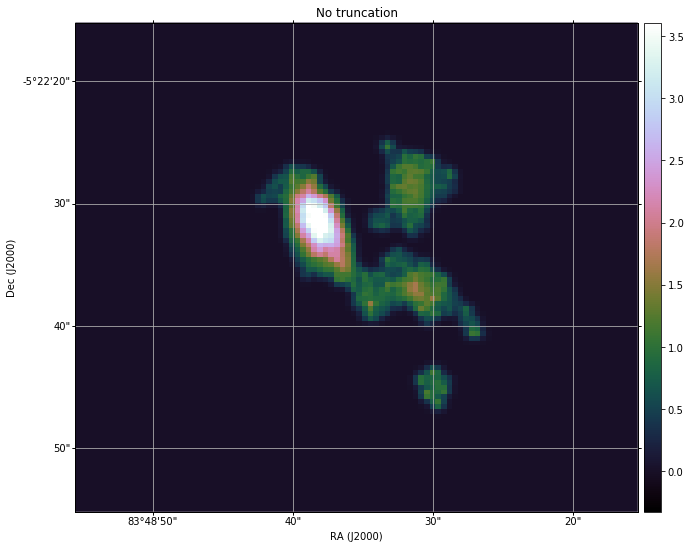

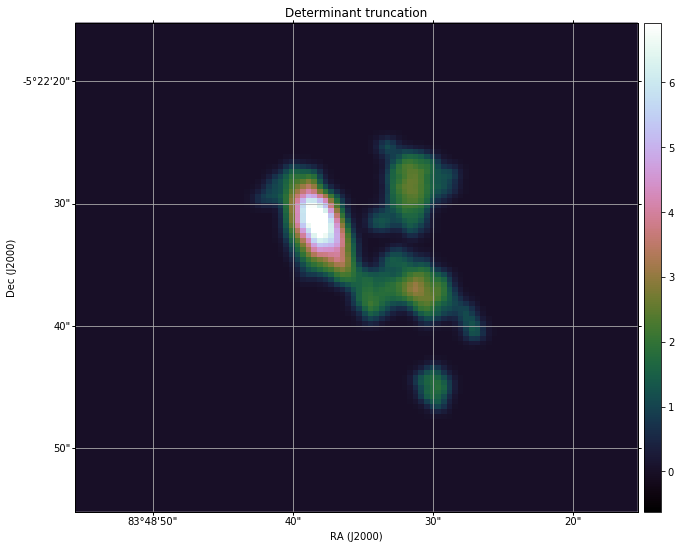

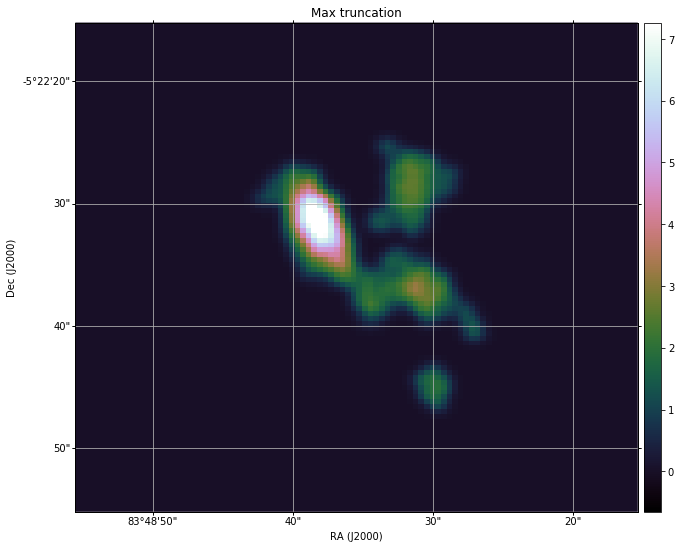

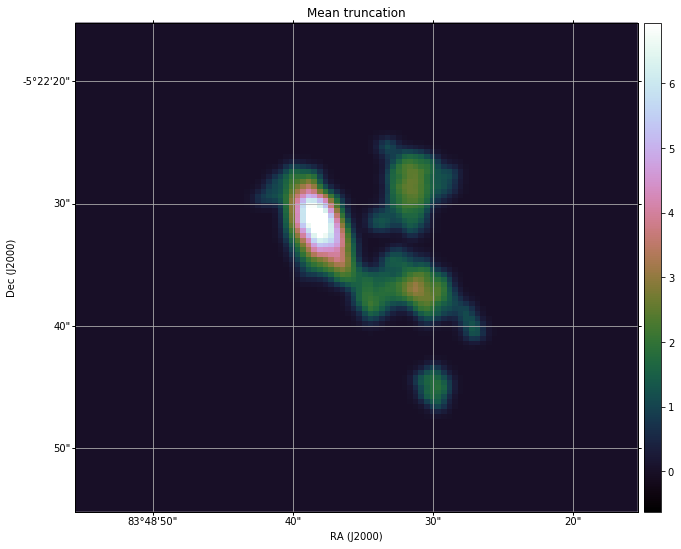

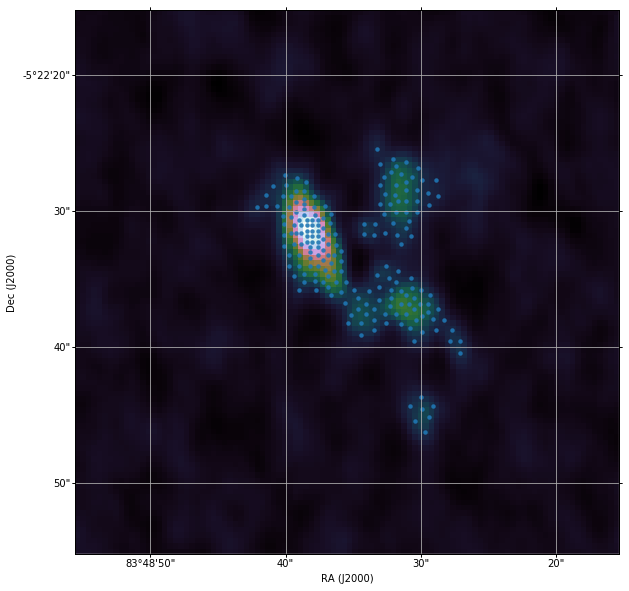


##########################
# k = 0.75
##########################
Initial sigma: 0.006666666666666667 

min and max sigma with determinant truncation:
0.006666666666666668
0.011363806723942962

min and max sigma with max truncation:
0.006666666666666667
0.013575186143930974

min and max sigma with mean truncation
0.006666666666666667
0.012481314187865527


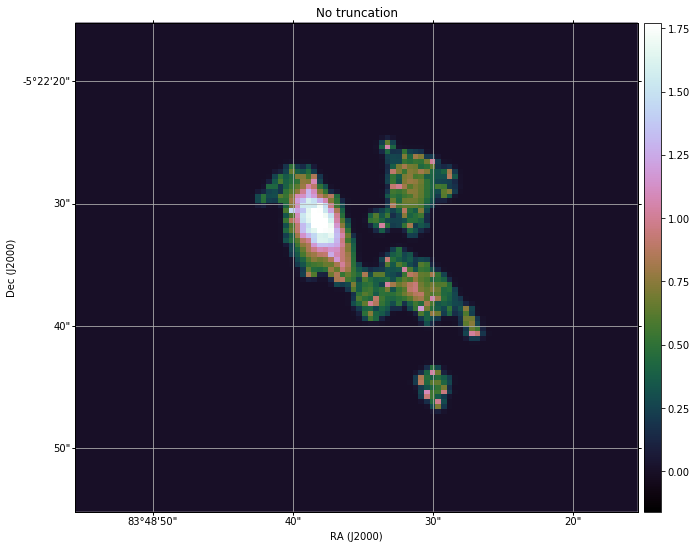

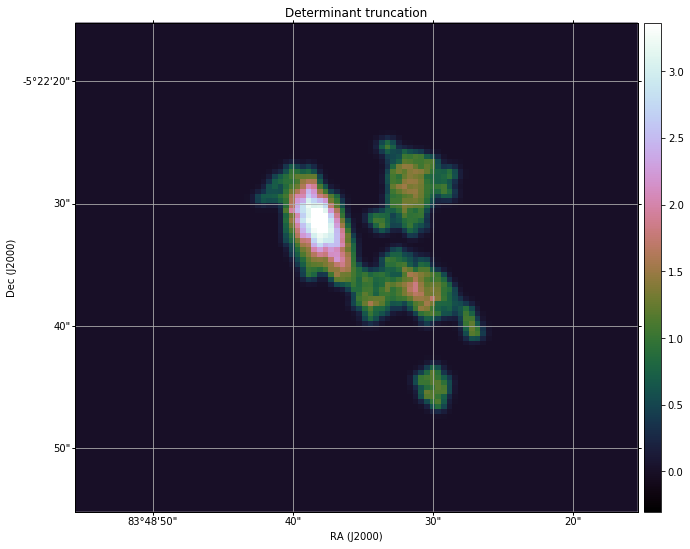

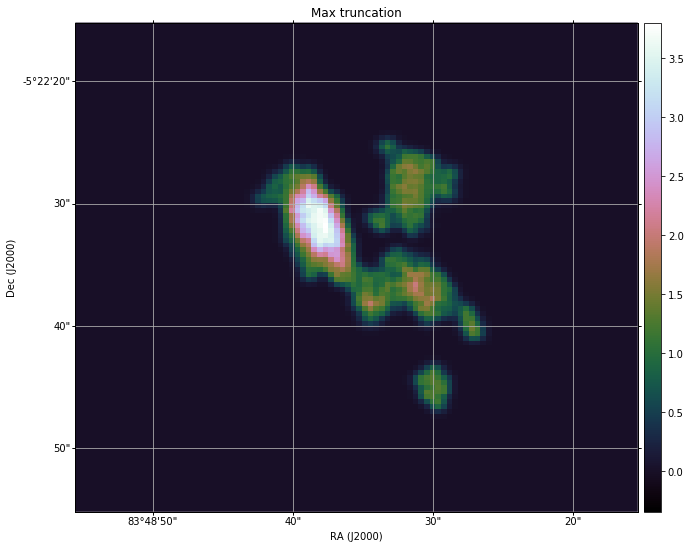

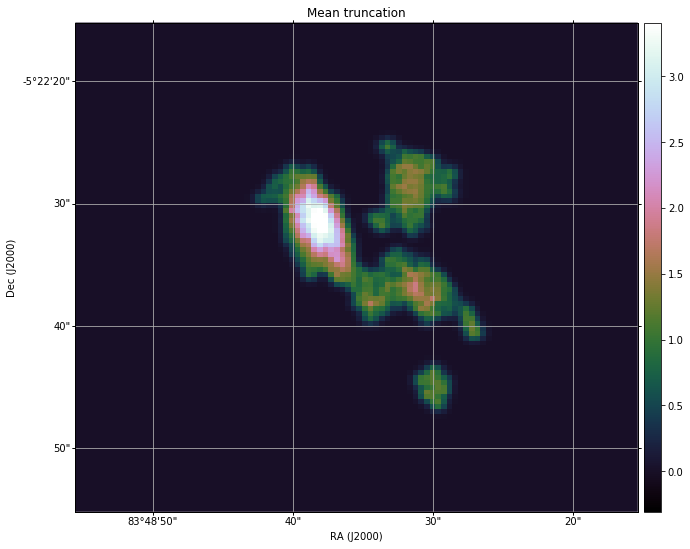

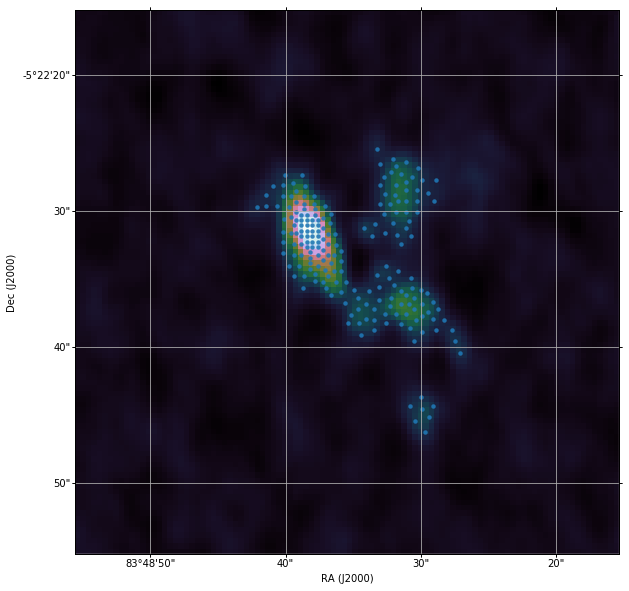


##########################
# k = 1.0
##########################
Initial sigma: 0.005 

min and max sigma with determinant truncation:
0.005000000000000002
0.010020273624122143

min and max sigma with max truncation:
0.005
0.0134175087612752

min and max sigma with mean truncation
0.005
0.011307319357537777


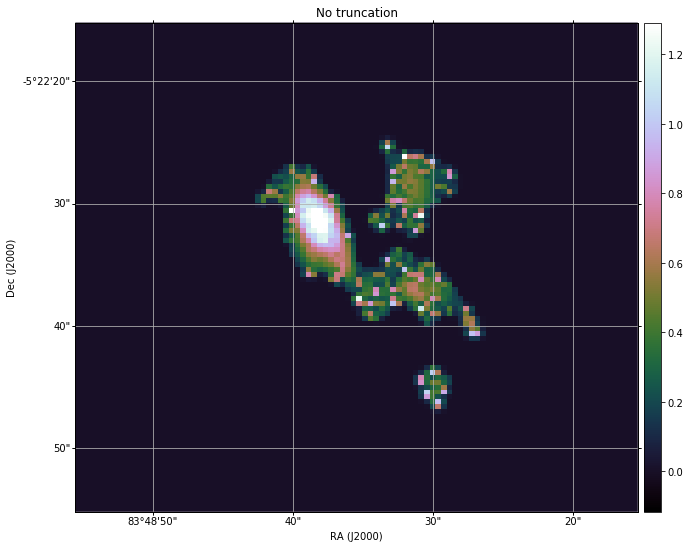

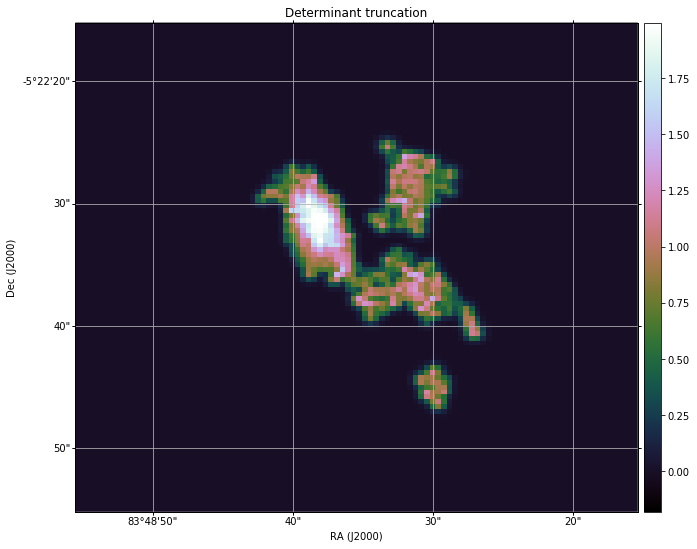

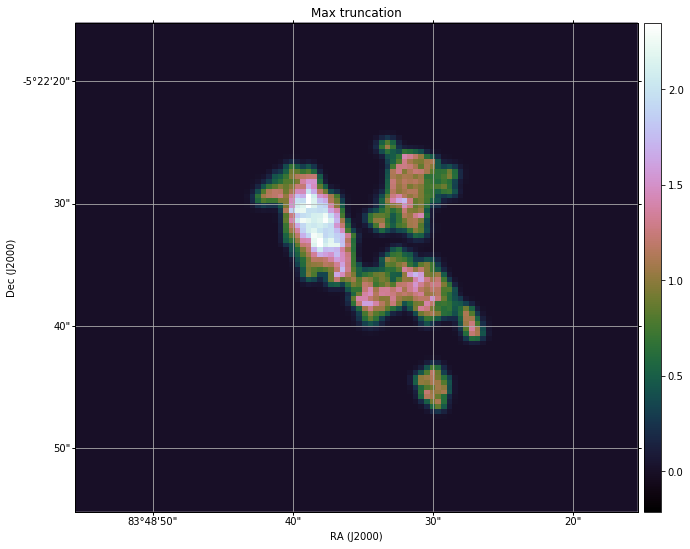

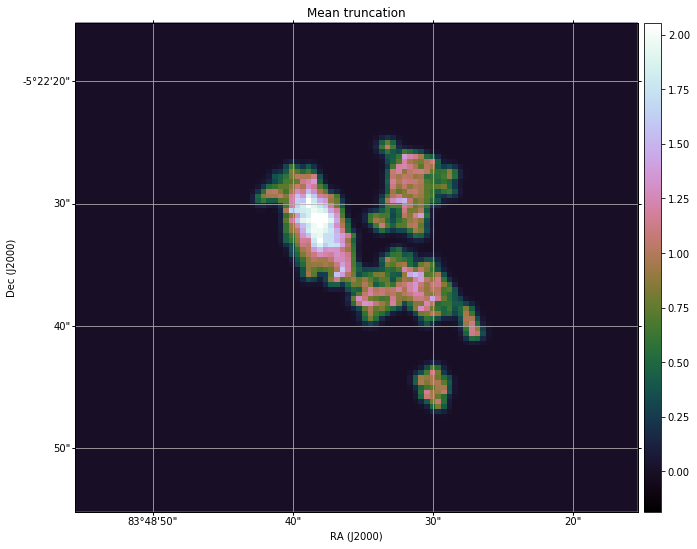

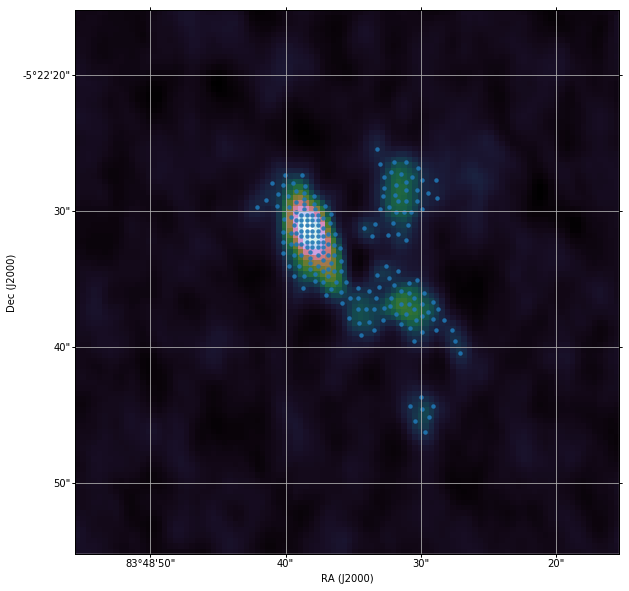


##########################
# k = 2.0
##########################
Initial sigma: 0.0025 

min and max sigma with determinant truncation:
0.002500000000000001
0.010402628556800393

min and max sigma with max truncation:
0.0025
0.03292443919384325

min and max sigma with mean truncation
0.0025
0.02334811230302229


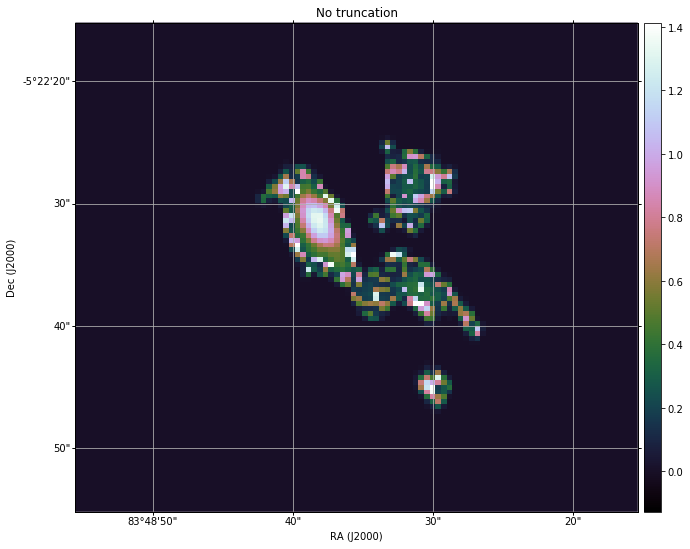

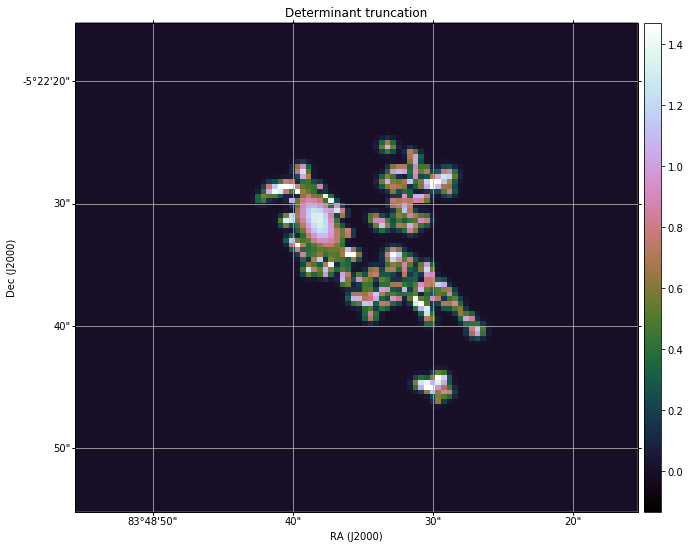

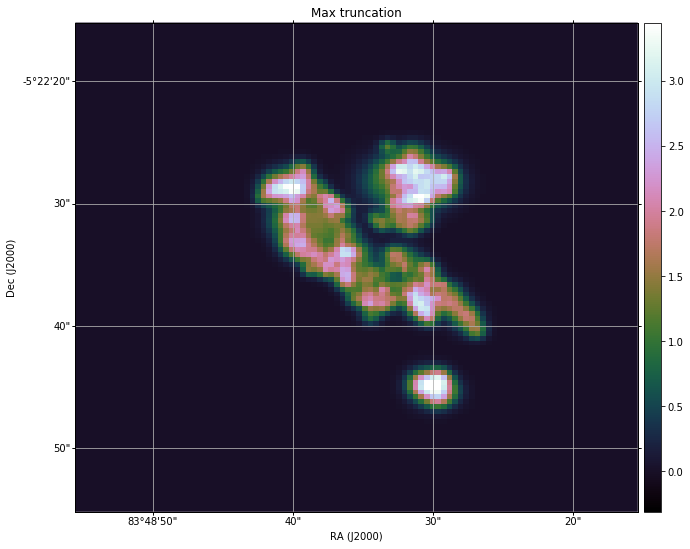

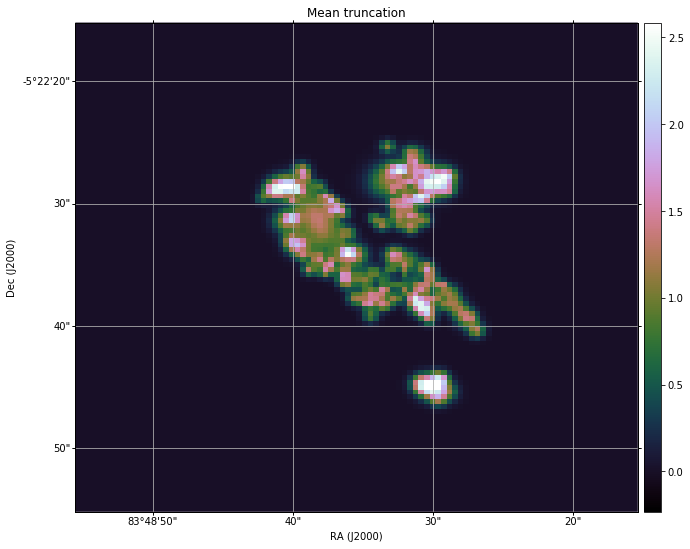

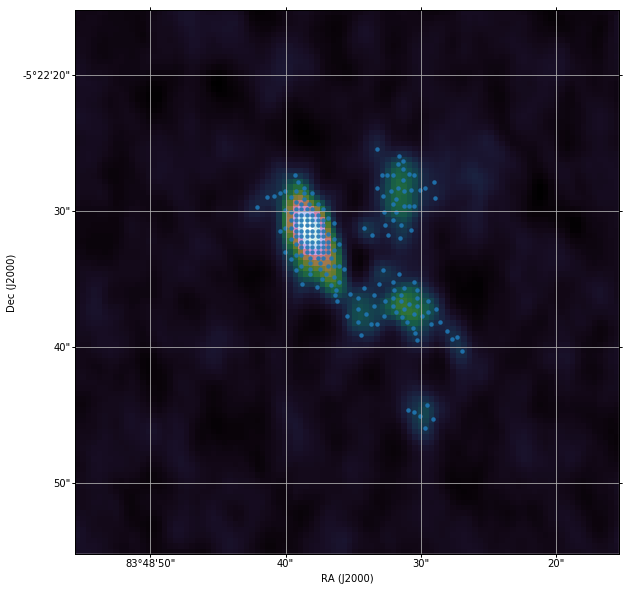


##########################
# k = 3.0
##########################
Initial sigma: 0.0016666666666666668 

min and max sigma with determinant truncation:
0.0016666666666666668
0.012111878148486329

min and max sigma with max truncation:
0.0016666666666666668
0.04339892115899211

min and max sigma with mean truncation
0.0016666666666666668
0.03071029253802535


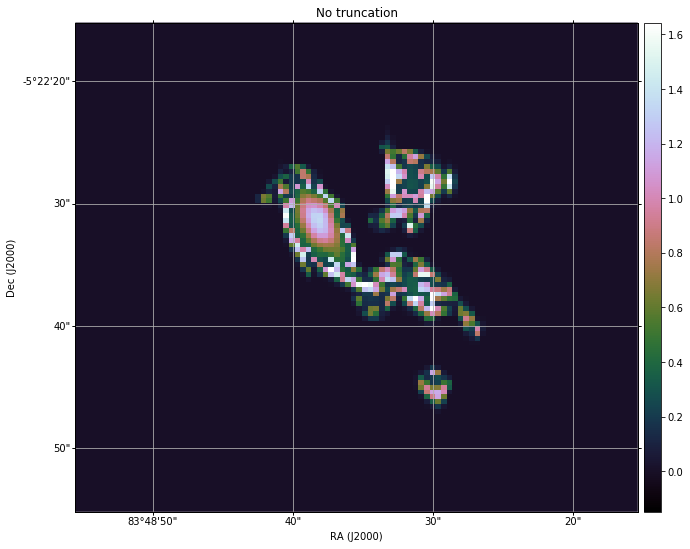

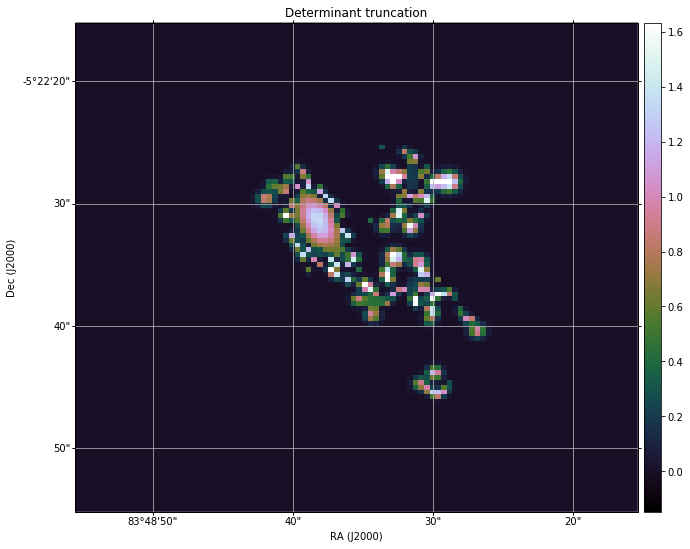

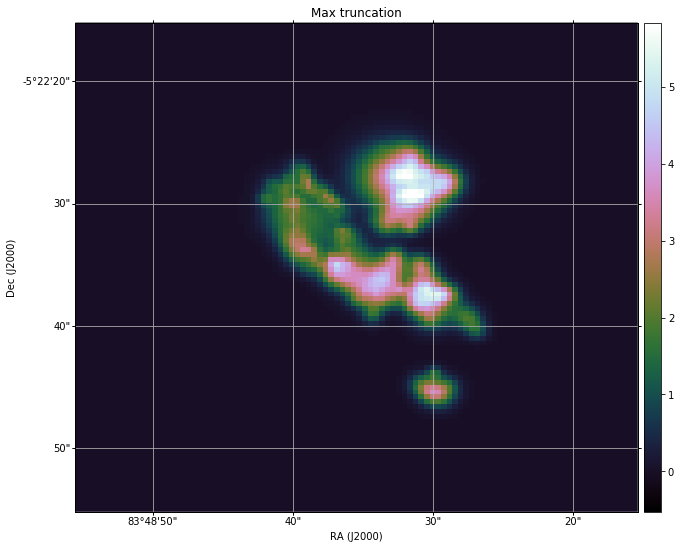

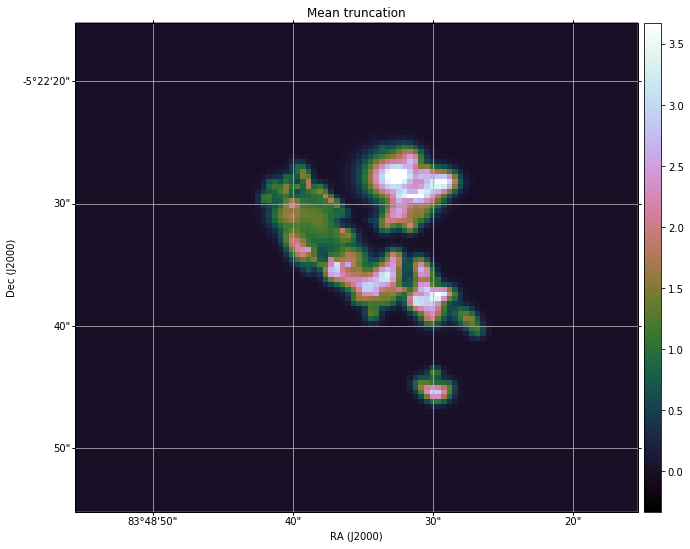

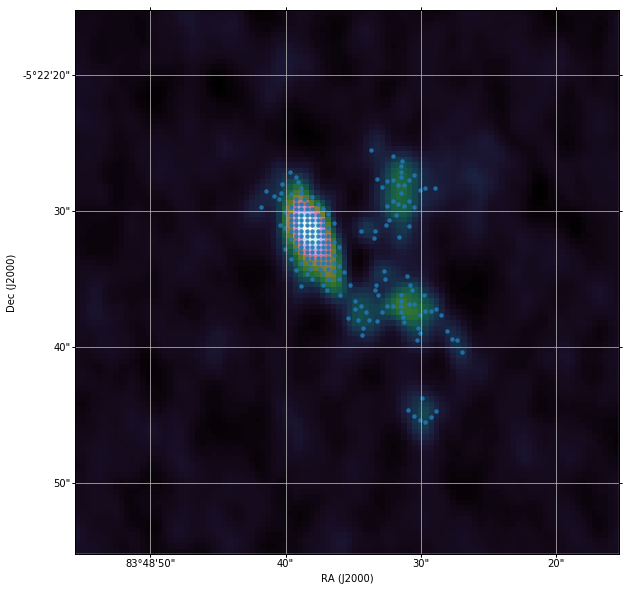


##########################
# k = 4.0
##########################
Initial sigma: 0.00125 

min and max sigma with determinant truncation:
0.0012500000000000002
0.011810065620845035

min and max sigma with max truncation:
0.00125
0.043245841653954196

min and max sigma with mean truncation
0.00125
0.03059219933544236


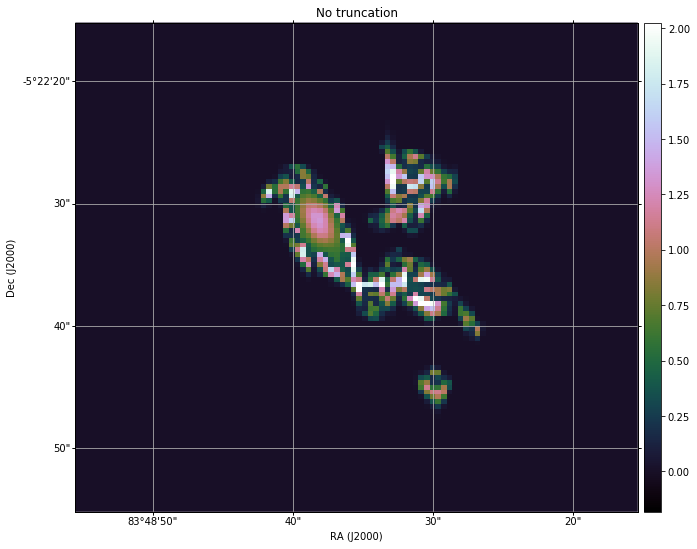

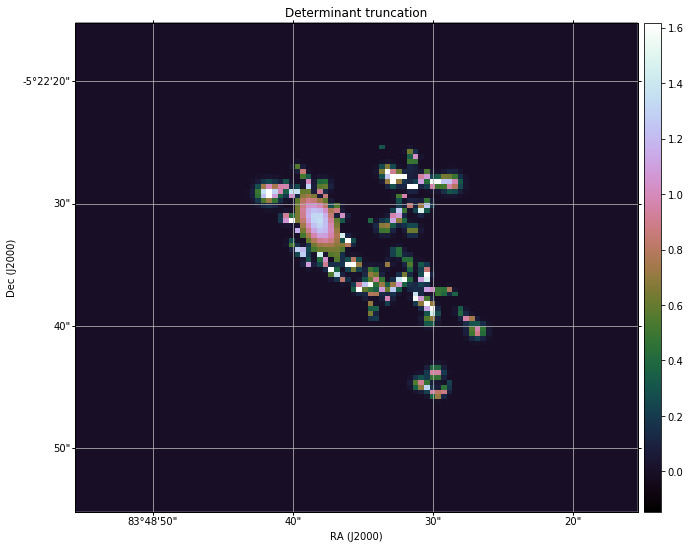

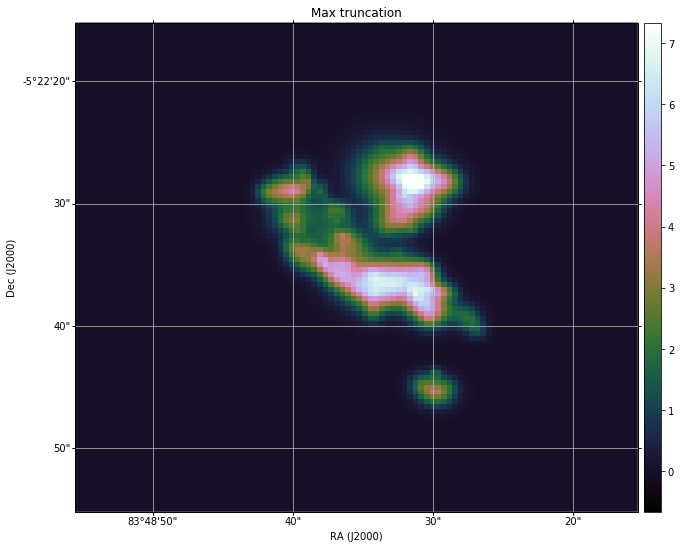

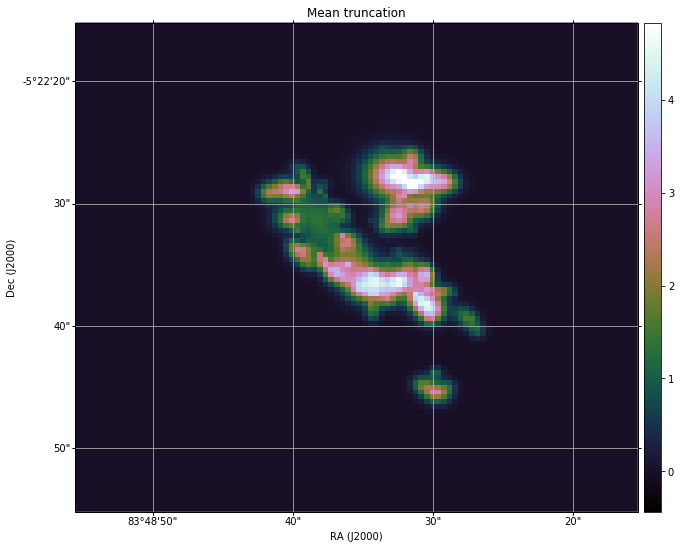

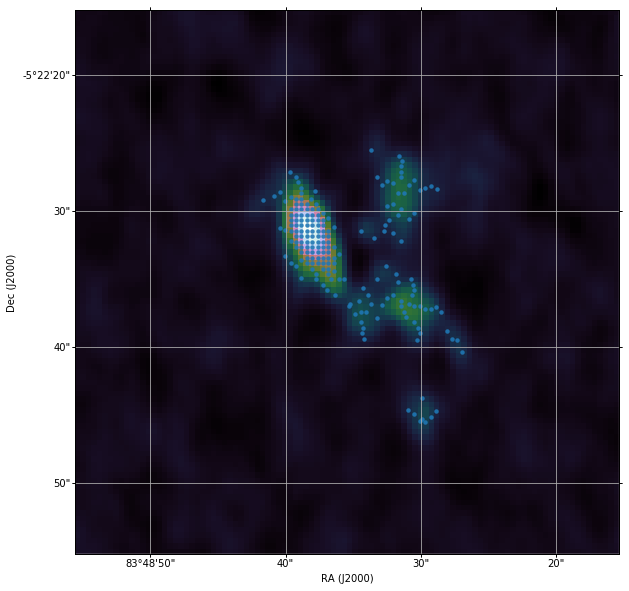


##########################
# k = 5.0
##########################
Initial sigma: 0.001 

min and max sigma with determinant truncation:
0.0010000000000000002
0.010998022410332901

min and max sigma with max truncation:
0.001
0.04629929182041157

min and max sigma with mean truncation
0.001
0.032746178579123014


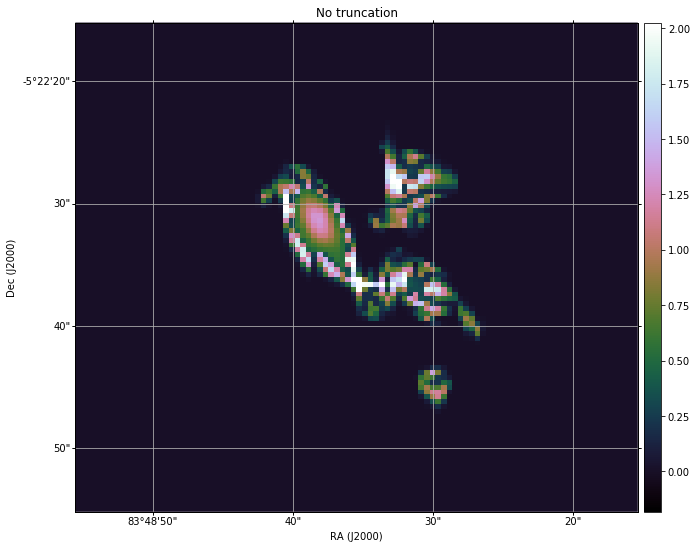

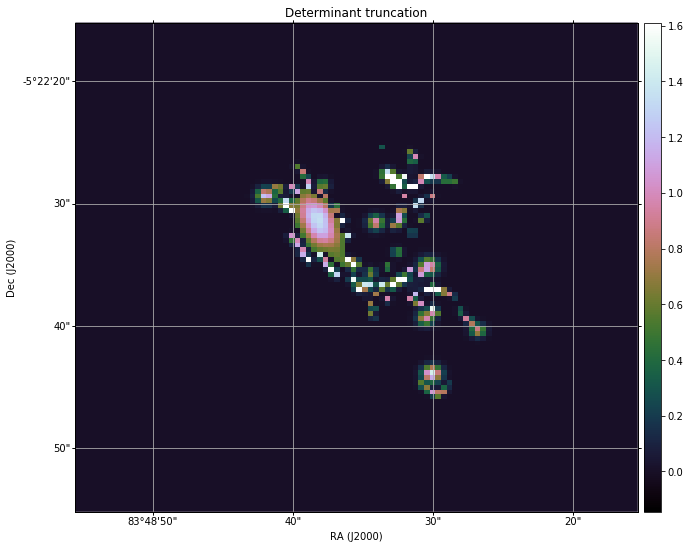

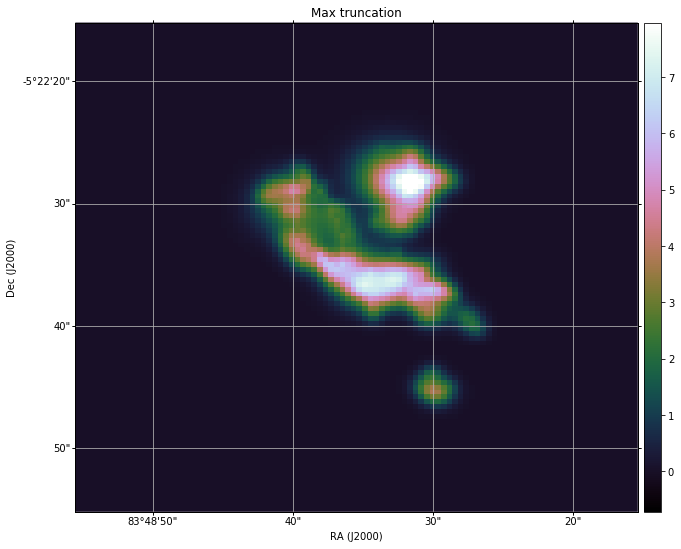

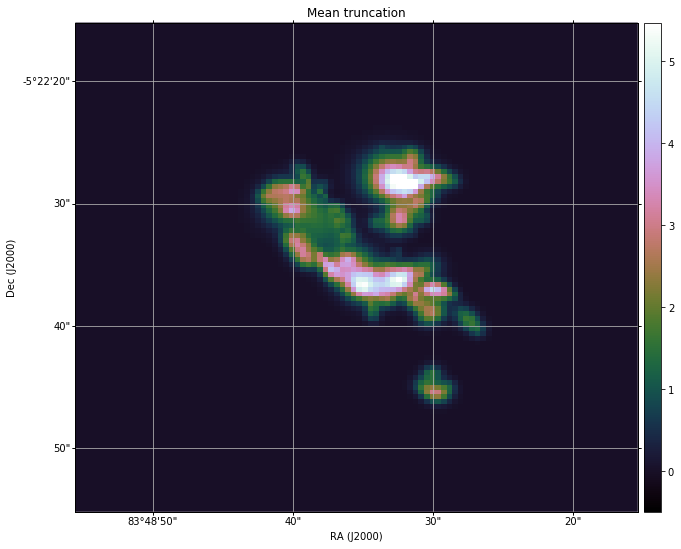

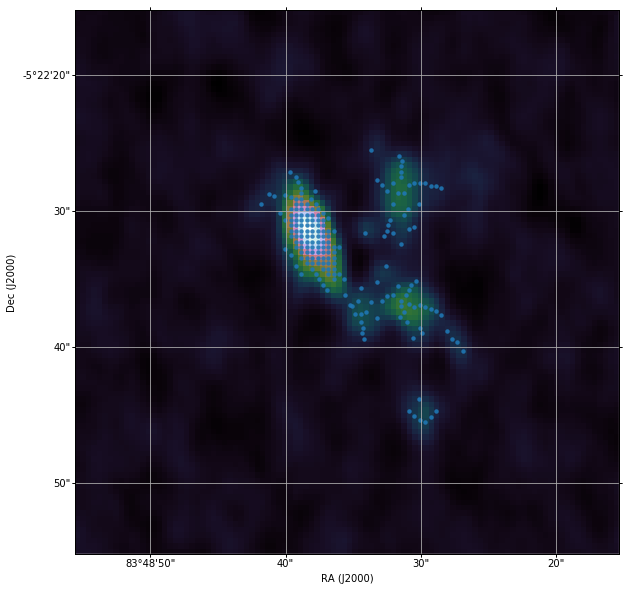

In [67]:
k_list = [0.1, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5.]

for k in k_list:
    print("\n##########################")
    print("# k =",k)
    print("##########################")
    initial_guess(data, mask, k=k)

#### Trying on a finer grid over `[0.1, 0.5]`


##########################
# k = 0.1
##########################
Initial sigma: 0.049999999999999996 

min and max sigma with determinant truncation:
0.05000000000000001
0.05072635672027981

min and max sigma with max truncation:
0.049999999999999996
0.051197892899913035

min and max sigma with mean truncation
0.049999999999999996
0.05072700496192099


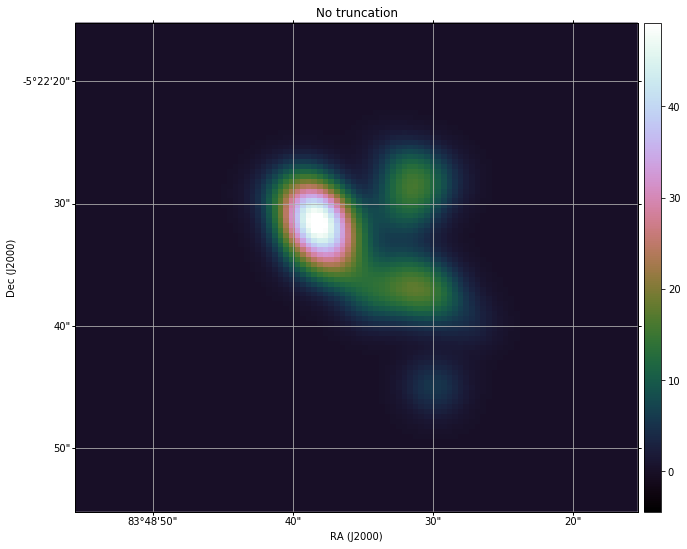

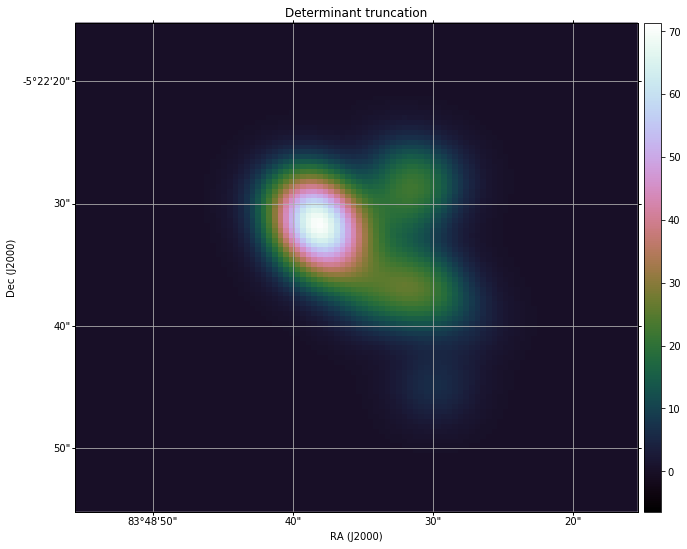

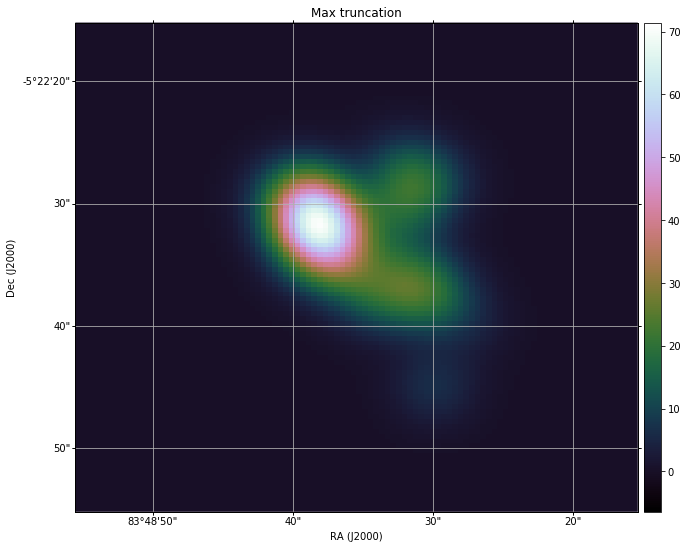

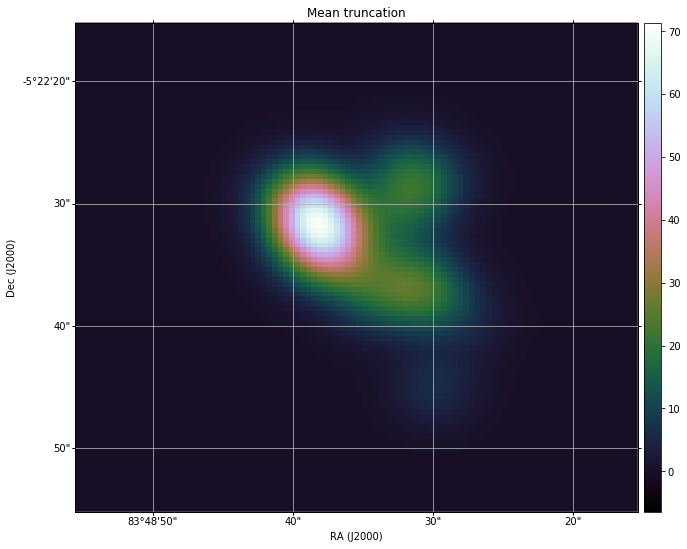

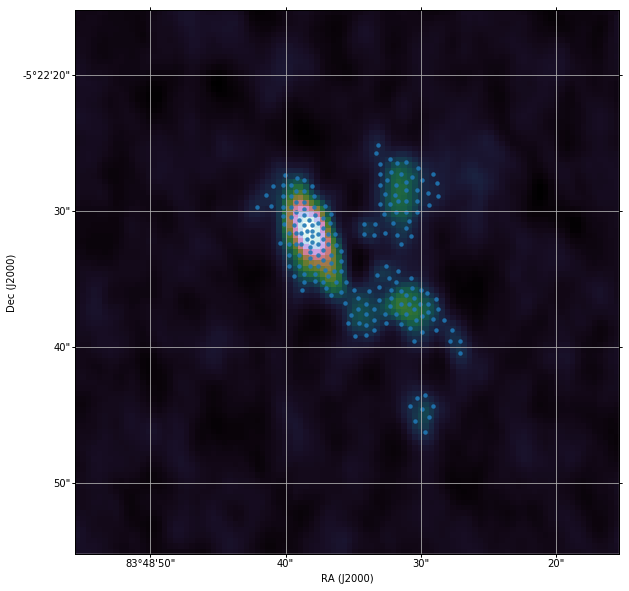


##########################
# k = 0.15
##########################
Initial sigma: 0.03333333333333333 

min and max sigma with determinant truncation:
0.03333333333333333
0.034412167115188894

min and max sigma with max truncation:
0.03333333333333333
0.0349835201522026

min and max sigma with mean truncation
0.03333333333333333
0.034414243323337326


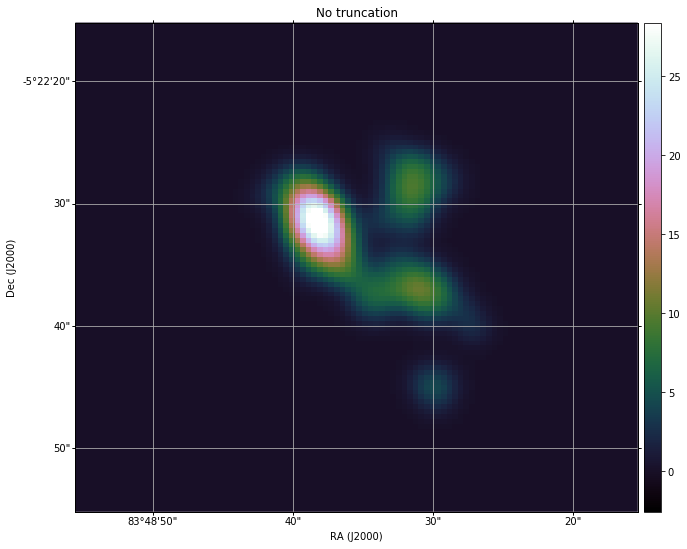

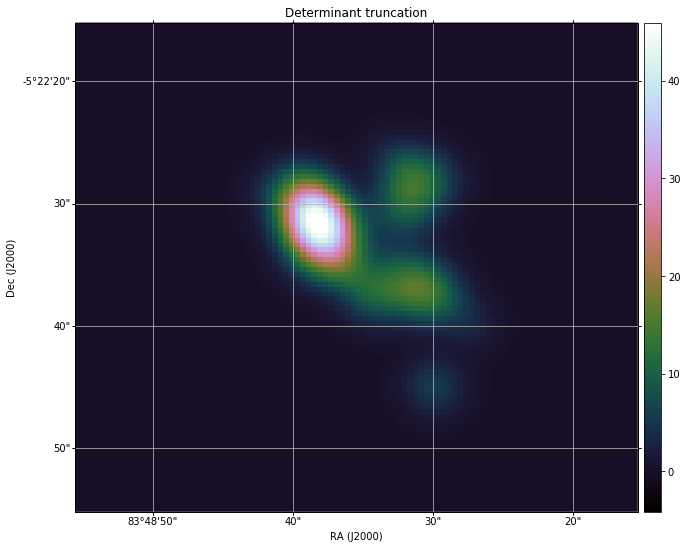

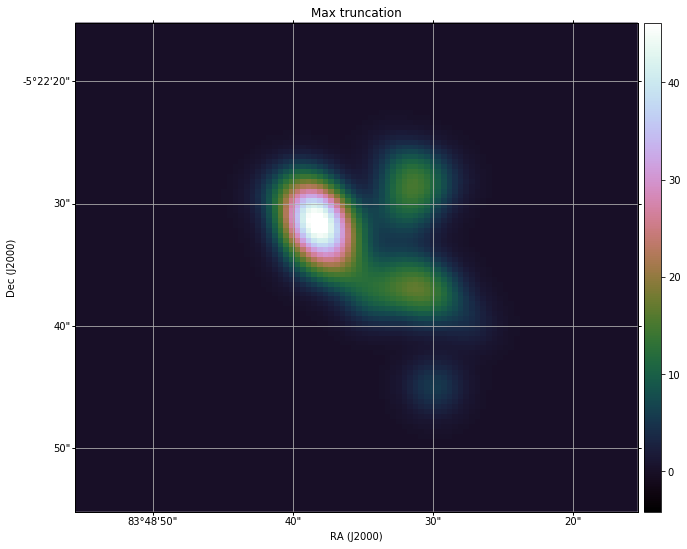

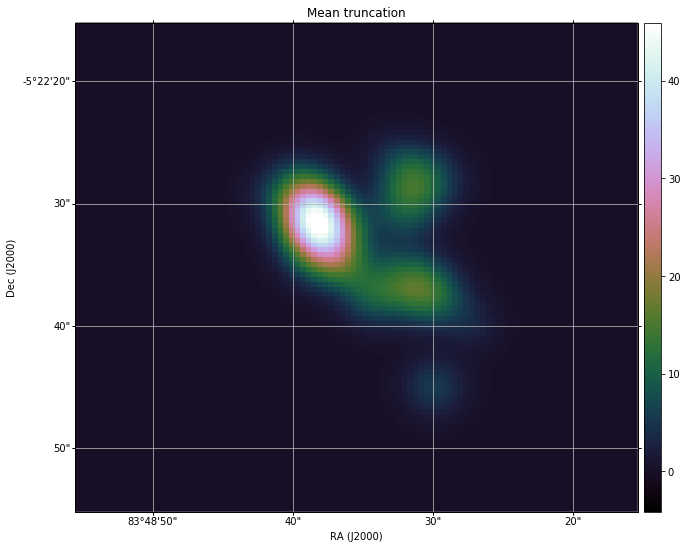

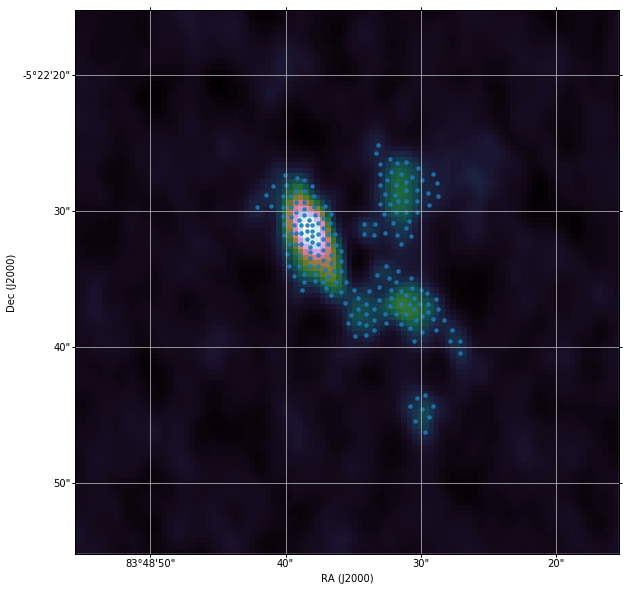


##########################
# k = 0.2
##########################
Initial sigma: 0.024999999999999998 

min and max sigma with determinant truncation:
0.025
0.02641943641731272

min and max sigma with max truncation:
0.024999999999999998
0.027161288097740394

min and max sigma with mean truncation
0.024999999999999998
0.02642402377395912


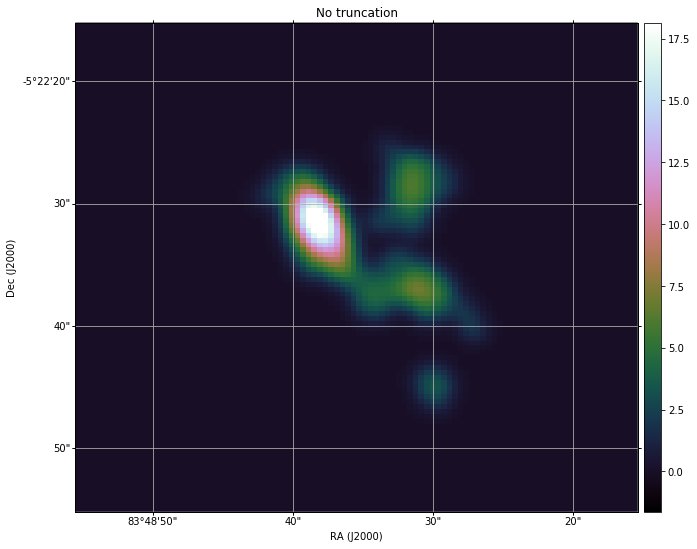

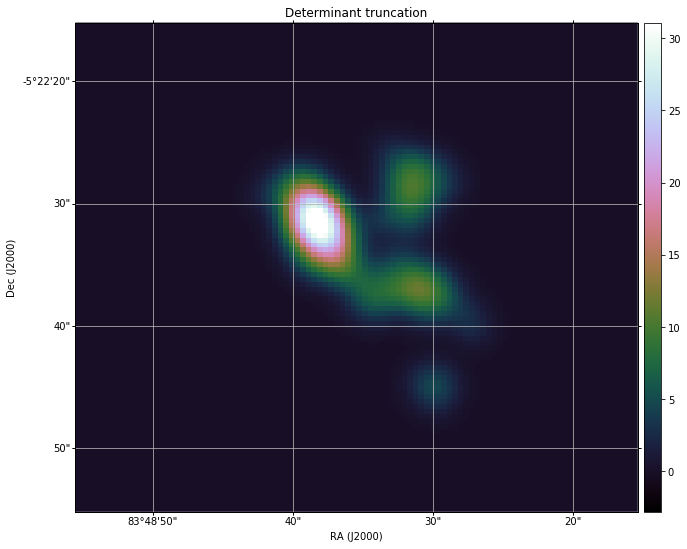

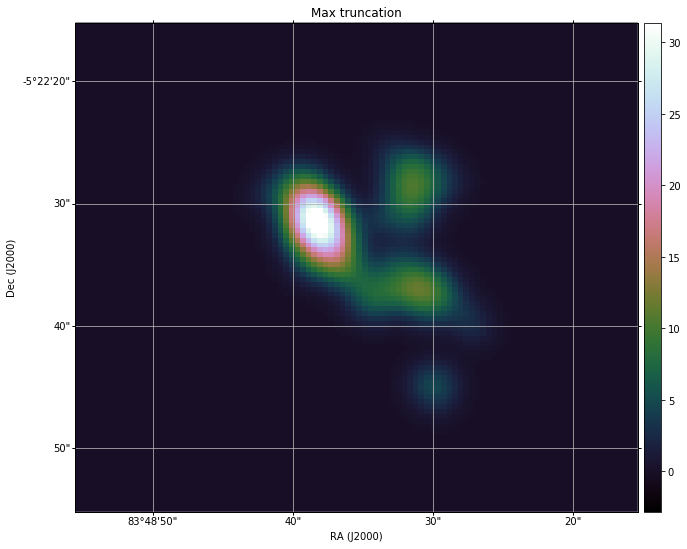

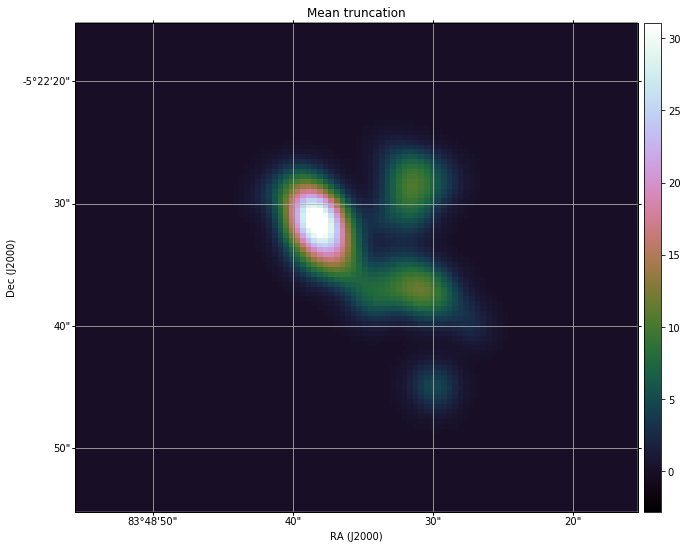

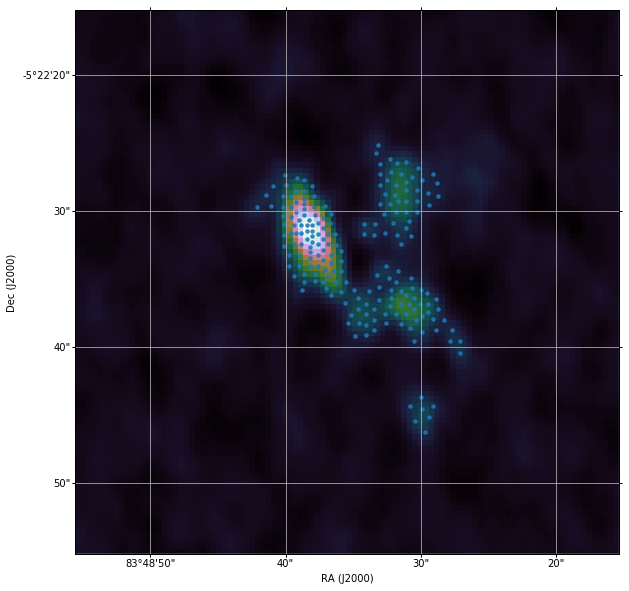


##########################
# k = 0.25
##########################
Initial sigma: 0.02 

min and max sigma with determinant truncation:
0.02
0.02174560394930044

min and max sigma with max truncation:
0.02
0.022643665143444736

min and max sigma with mean truncation
0.02
0.02175382799432681


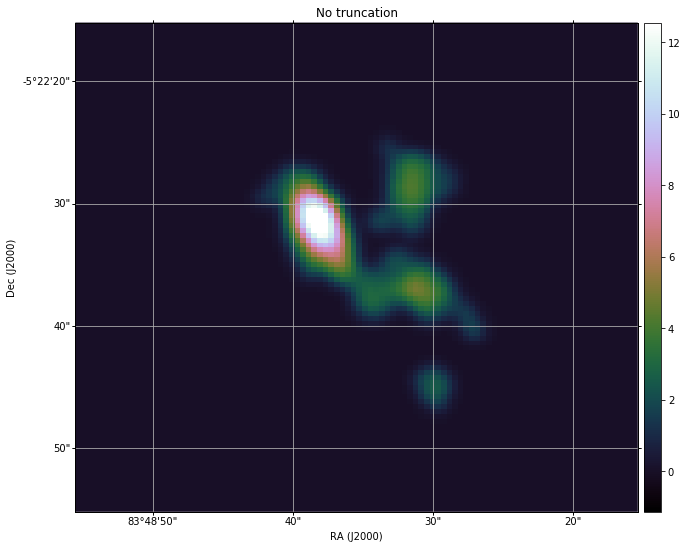

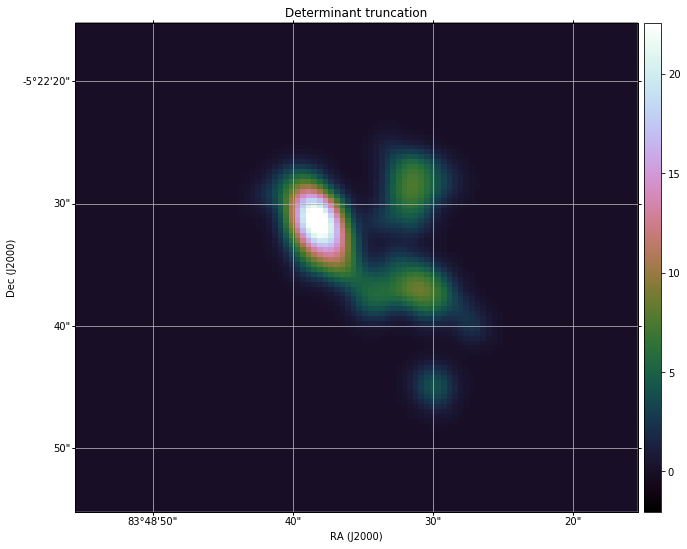

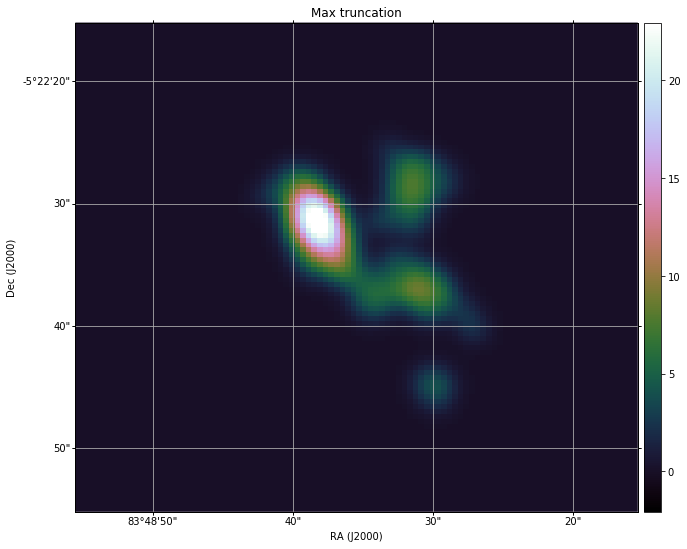

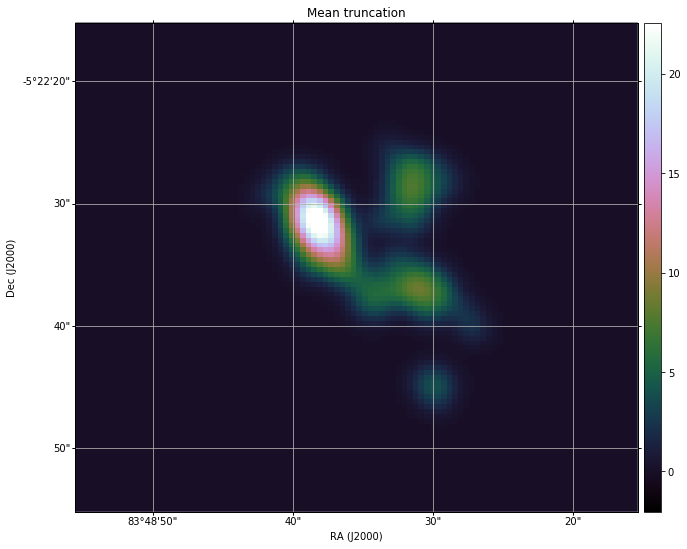

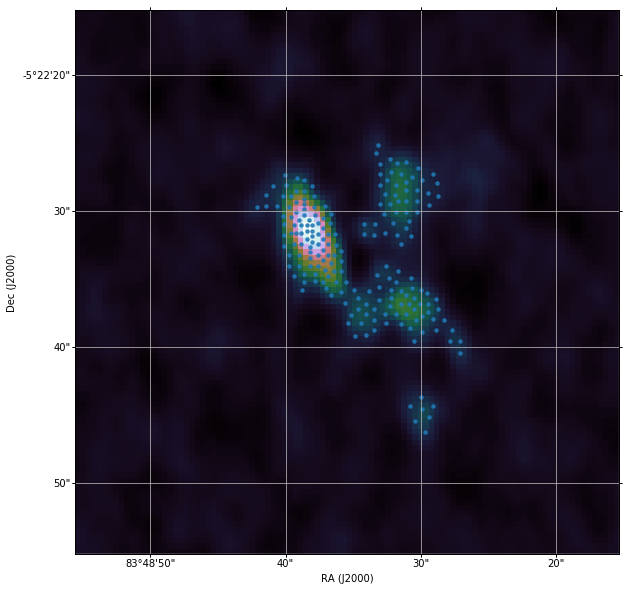


##########################
# k = 0.3
##########################
Initial sigma: 0.016666666666666666 

min and max sigma with determinant truncation:
0.01666666666666667
0.01878100468492228

min and max sigma with max truncation:
0.016666666666666666
0.019761410600112328

min and max sigma with mean truncation
0.016666666666666666
0.018792975735937936


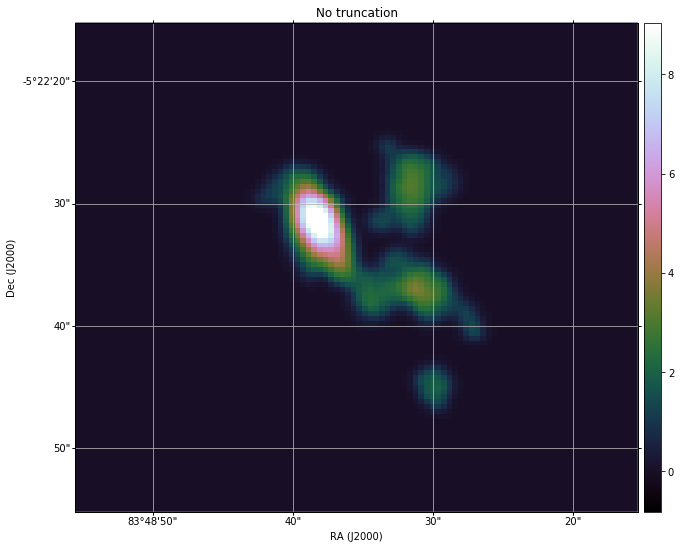

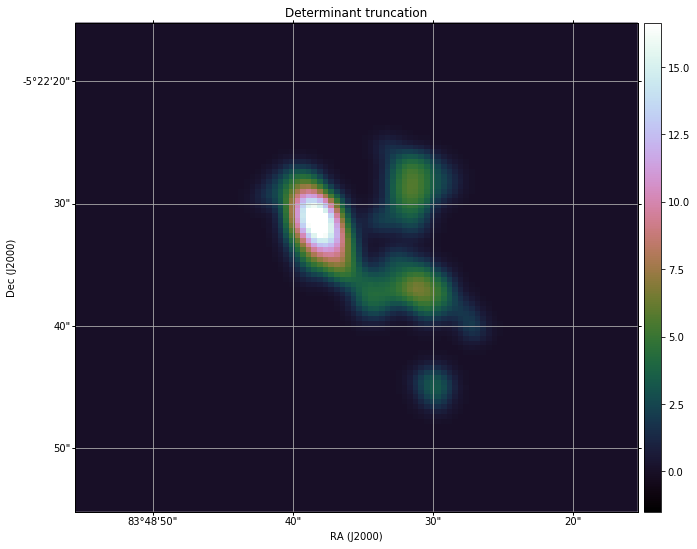

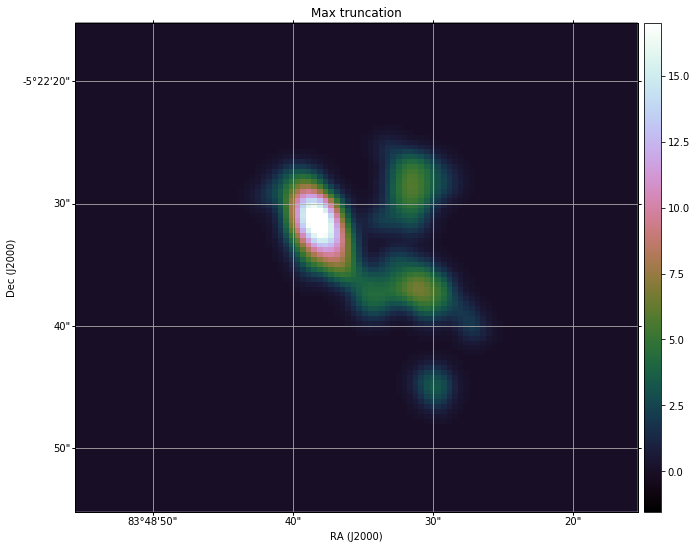

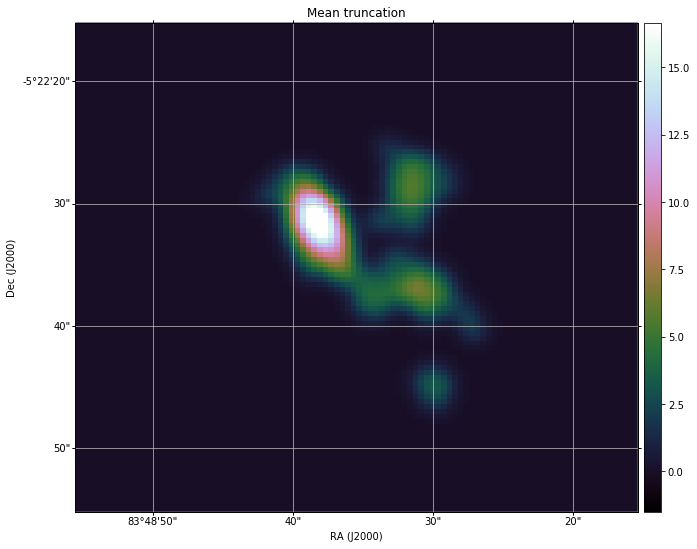

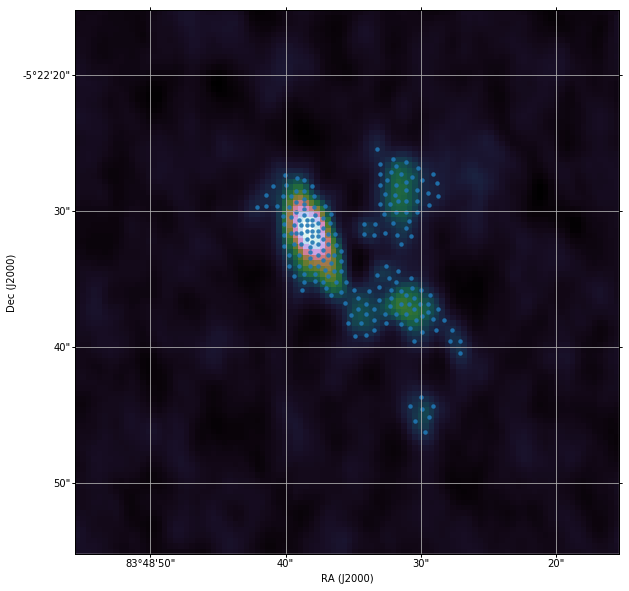


##########################
# k = 0.35
##########################
Initial sigma: 0.014285714285714287 

min and max sigma with determinant truncation:
0.014285714285714292
0.01670063374214673

min and max sigma with max truncation:
0.014285714285714287
0.017799359645265765

min and max sigma with mean truncation
0.014285714285714287
0.016717649113641413


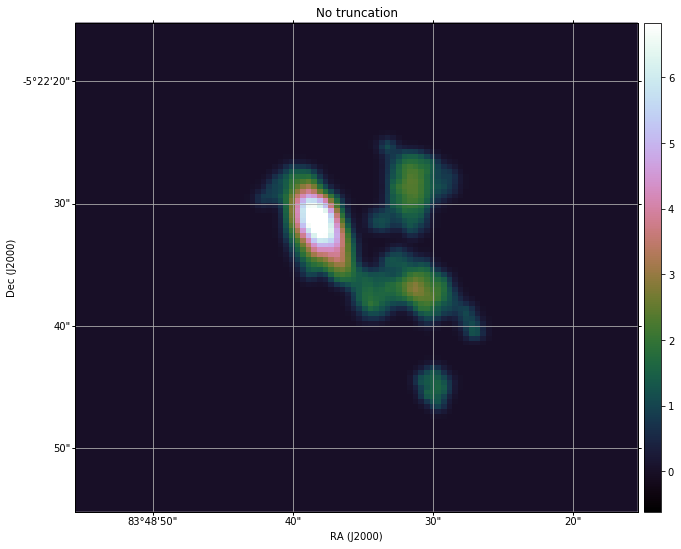

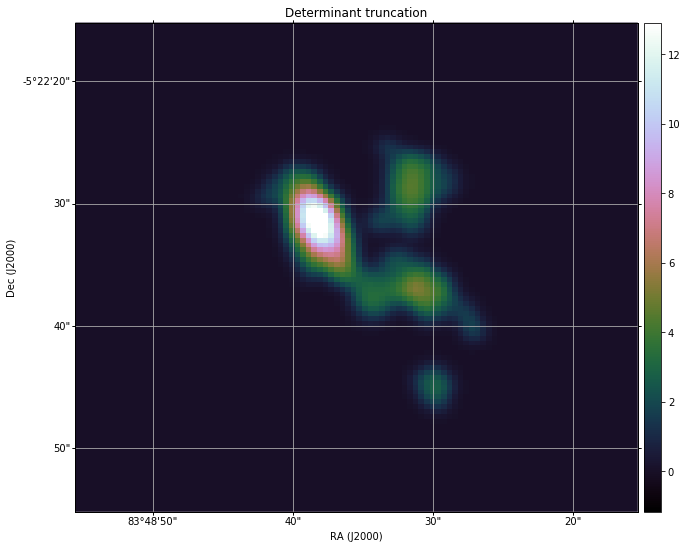

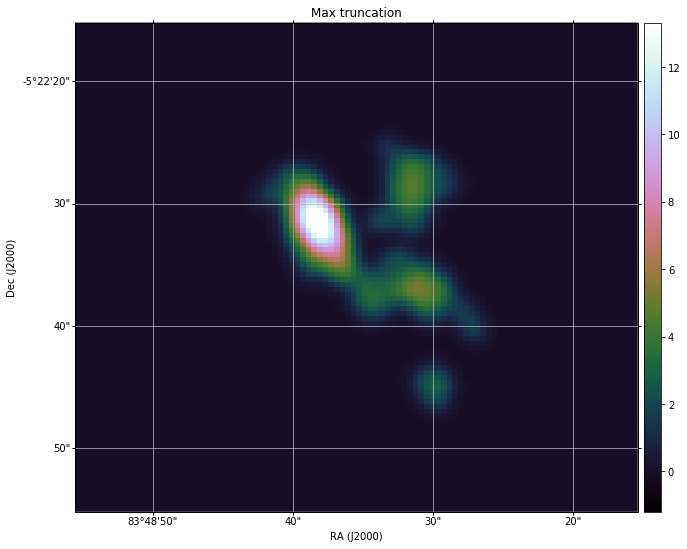

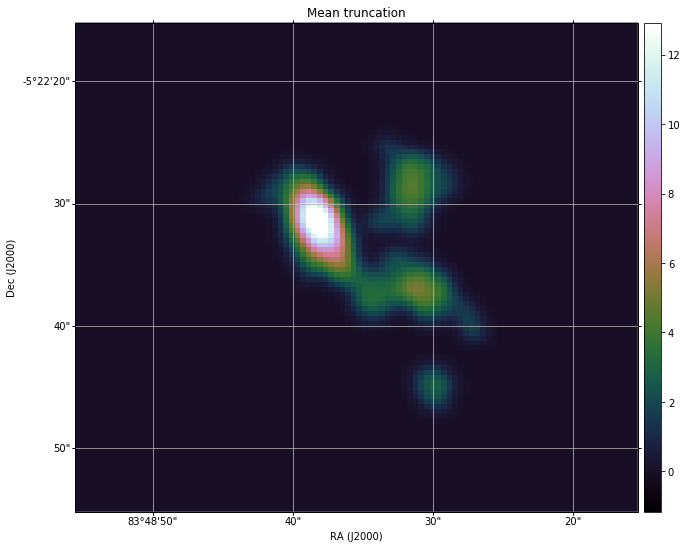

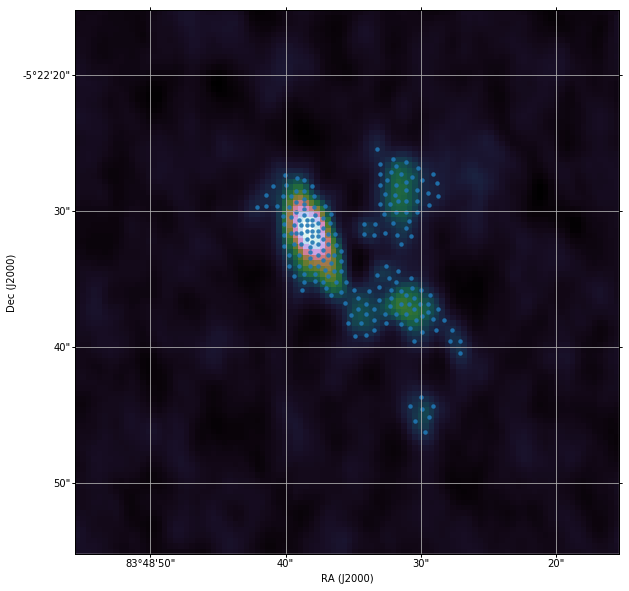


##########################
# k = 0.4
##########################
Initial sigma: 0.012499999999999999 

min and max sigma with determinant truncation:
0.012499999999999994
0.015197427544823222

min and max sigma with max truncation:
0.012499999999999999
0.017057680198014052

min and max sigma with mean truncation
0.012499999999999999
0.01521999209046359


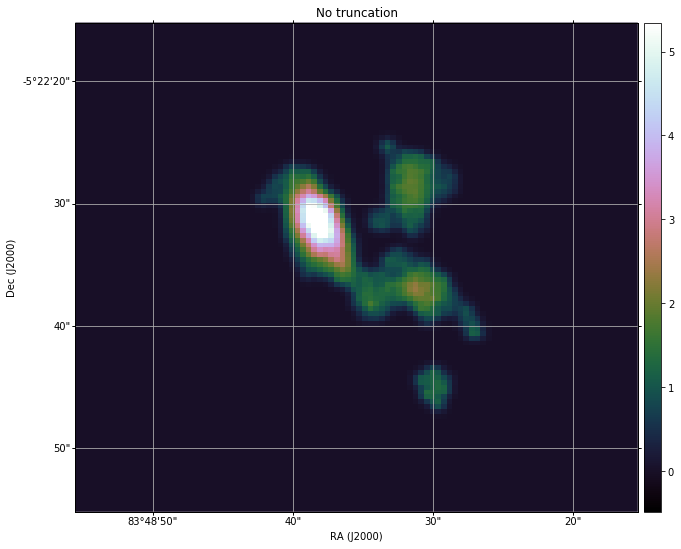

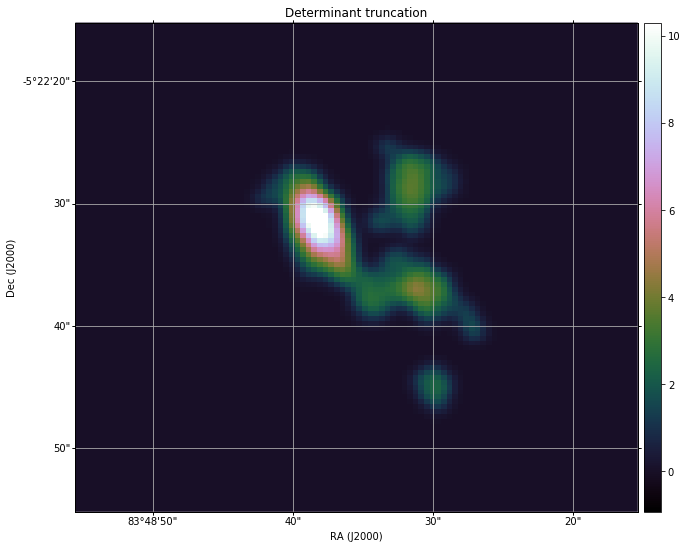

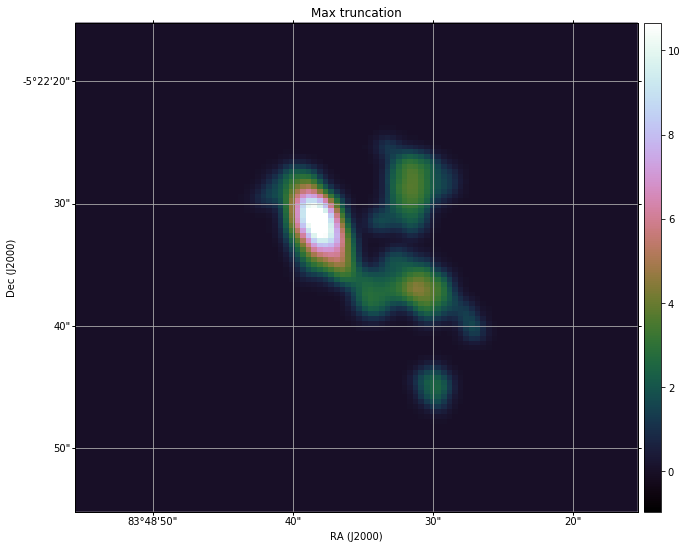

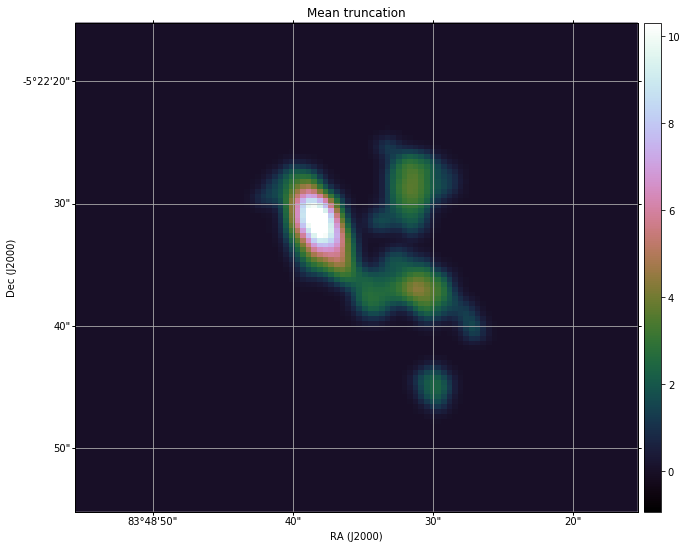

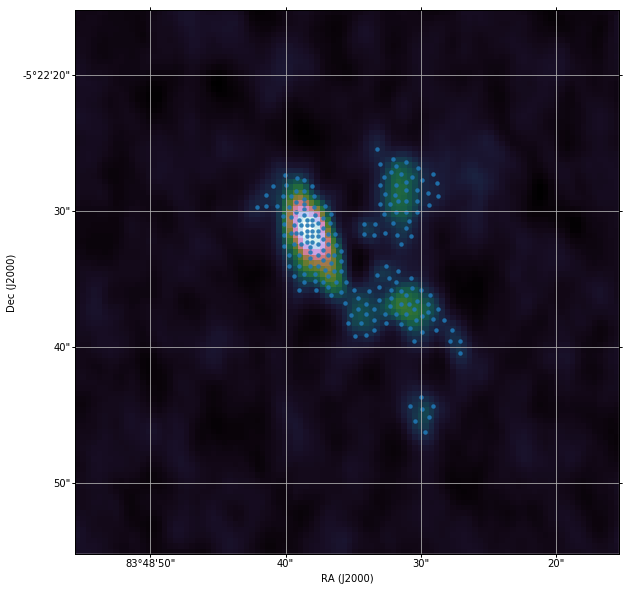


##########################
# k = 0.45
##########################
Initial sigma: 0.011111111111111112 

min and max sigma with determinant truncation:
0.011111111111111112
0.014073200863012732

min and max sigma with max truncation:
0.011111111111111112
0.01622646062828822

min and max sigma with mean truncation
0.011111111111111112
0.014338621978022879


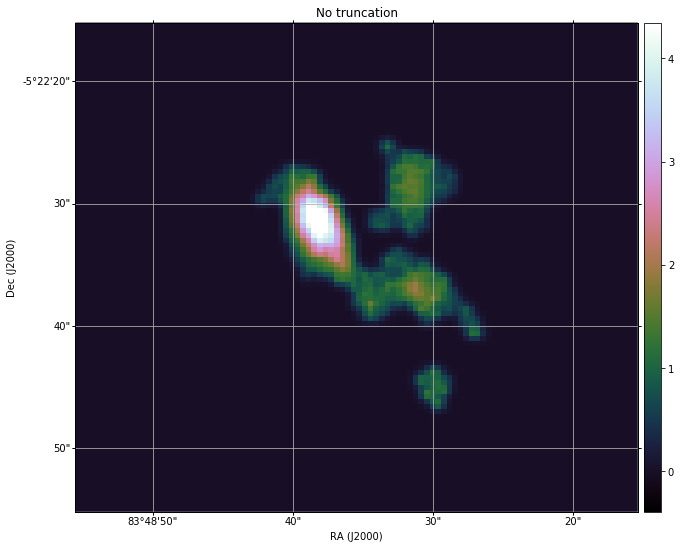

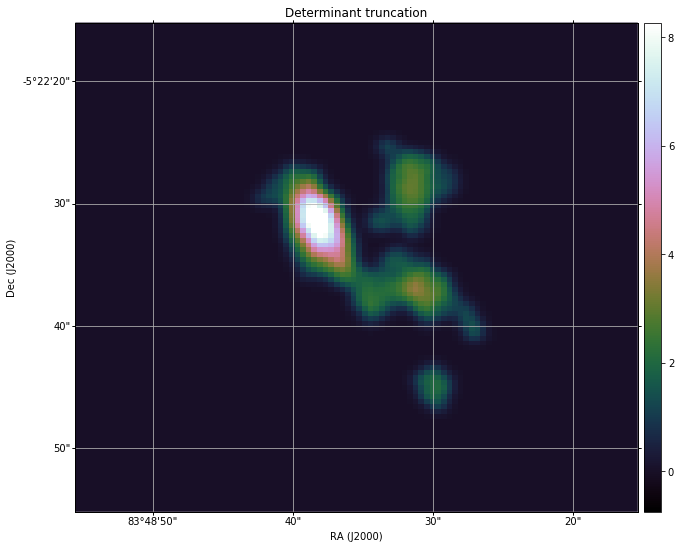

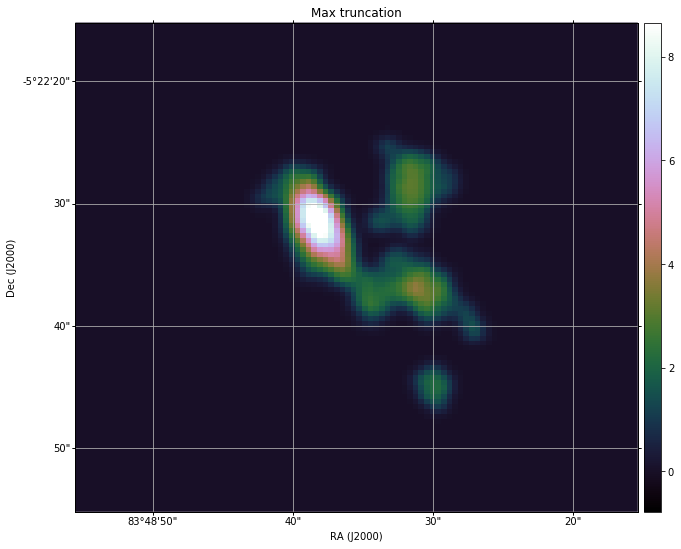

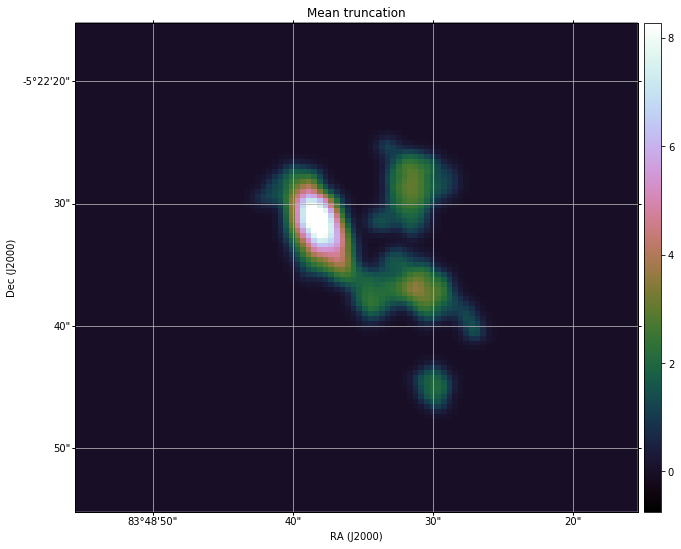

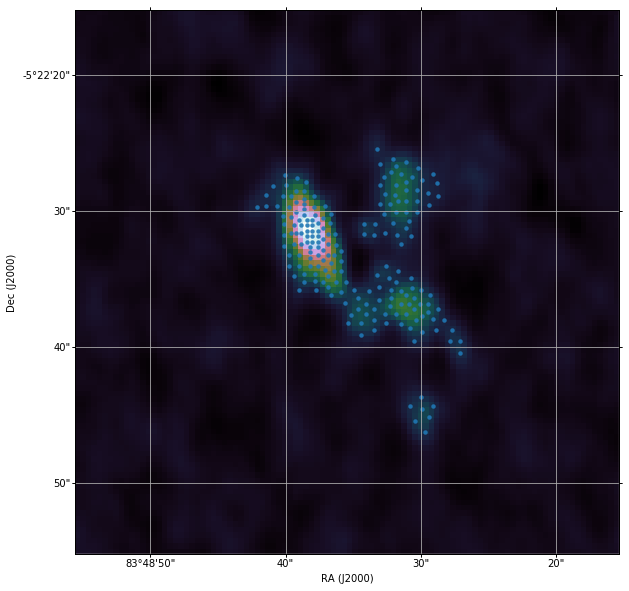


##########################
# k = 0.5
##########################
Initial sigma: 0.01 

min and max sigma with determinant truncation:
0.010000000000000005
0.013349817507525338

min and max sigma with max truncation:
0.01
0.015486808399342035

min and max sigma with mean truncation
0.01
0.013495899010632226


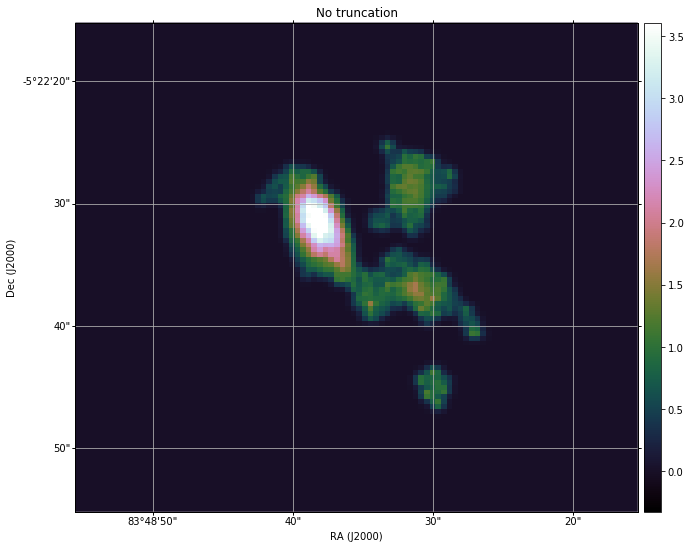

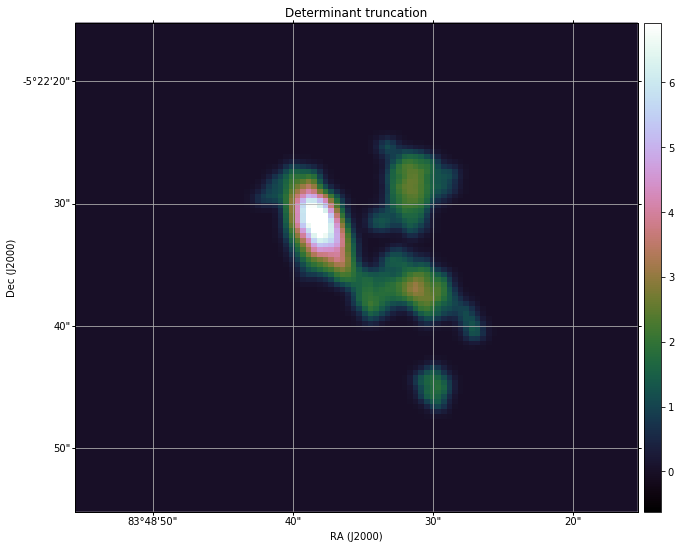

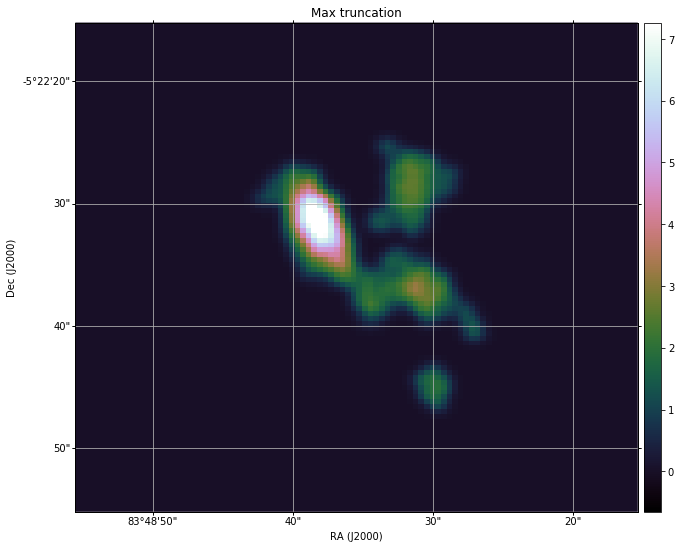

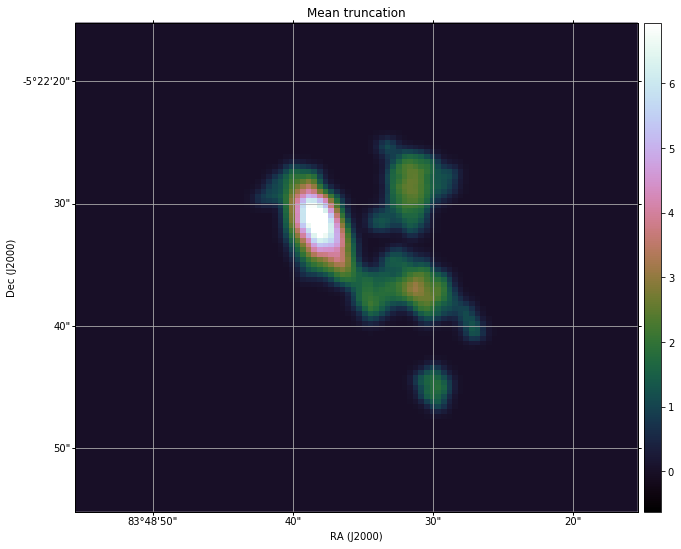

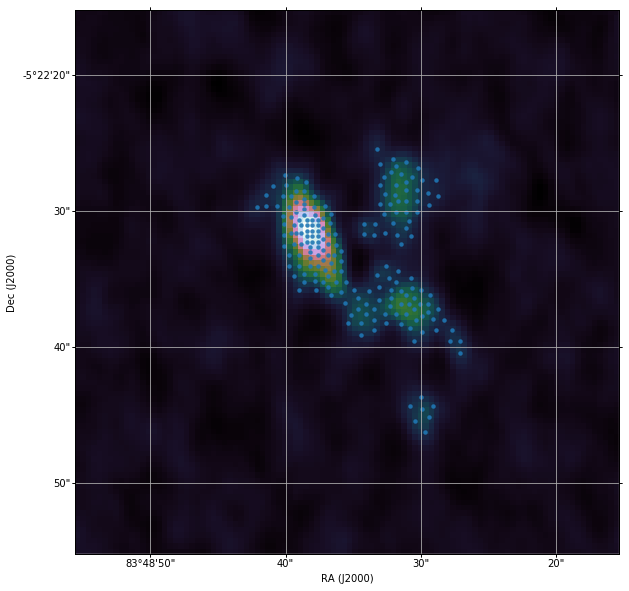

In [73]:
k_list = [0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for k in k_list:
    print("\n##########################")
    print("# k =",k)
    print("##########################")
    initial_guess(data, mask, k=k)

## Isomorphic gaussian agglomeration tests

In [17]:
k_list = [0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]

for k in k_list:
    print("\n##########################")
    print("# k =",k)
    print("##########################")
    initial_guess(data, mask, k=k, isomorphic=True)


##########################
# k = 0.1
##########################
Initial sigma: 0.049999999999999996 



LinAlgError: Array must not contain infs or NaNs.

Initial sigma: 0.016666666666666666 

min and max sigma with isomorphic merge:
0.0
0.00027777777827834037


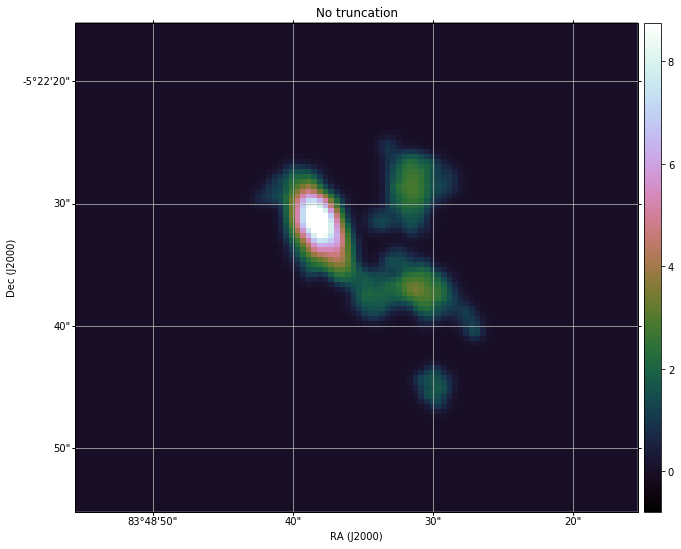

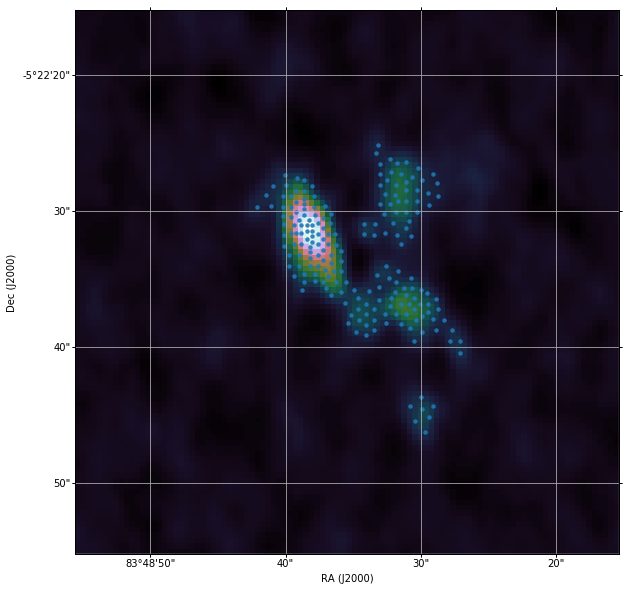

In [15]:
out = initial_guess(data, mask, k=k, isomorphic=True)

Initial sigma: 0.016666666666666666 

min and max sigma with determinant truncation:
0.01666666666666667
0.01878100468492228

min and max sigma with max truncation:
0.016666666666666666
0.019761410600112328

min and max sigma with mean truncation
0.016666666666666666
0.018792975735937936


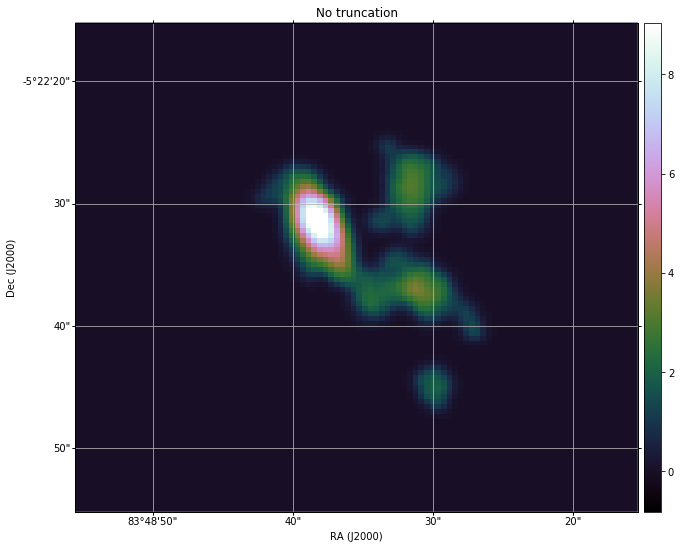

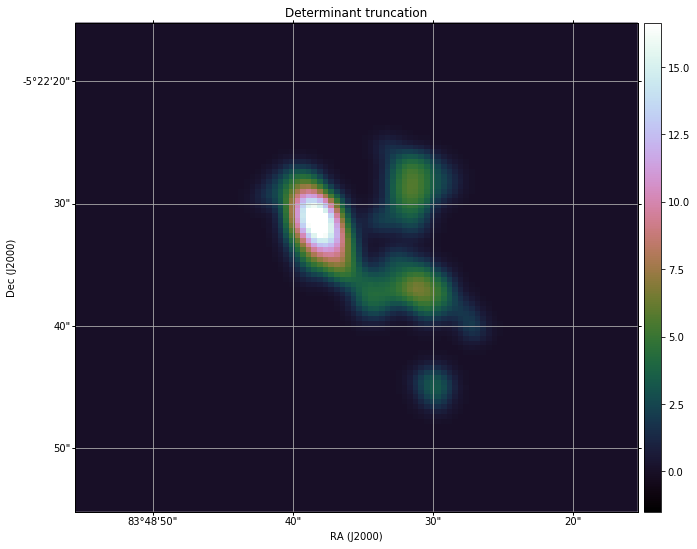

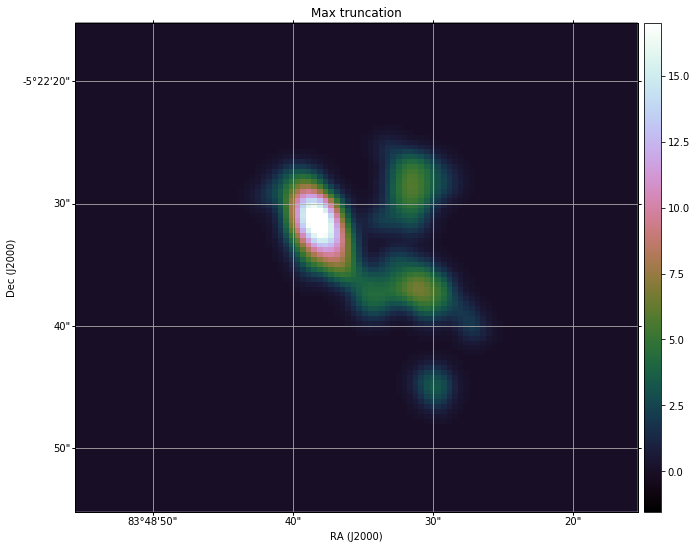

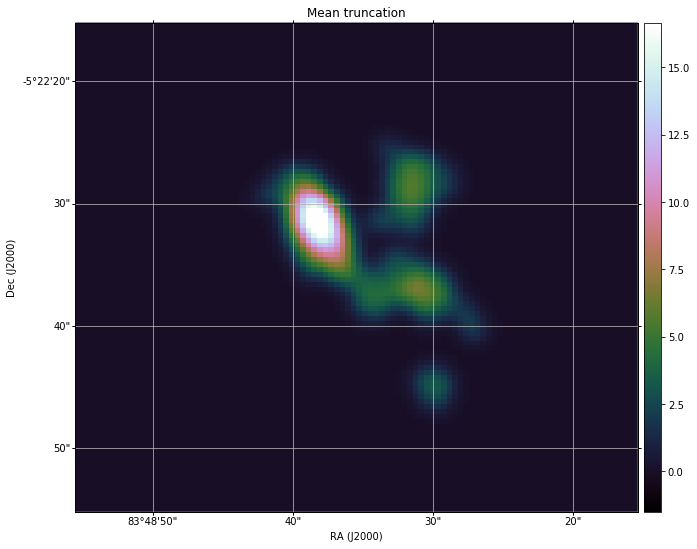

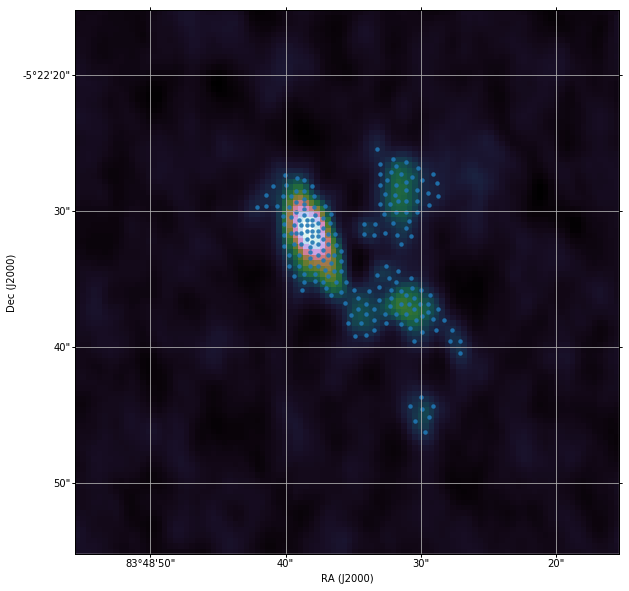

In [17]:
initial_guess(data, mask, k=k)

***
***

## Tests on improving `u_eval_full()`

In [17]:
import numba

In [37]:
@numba.jit('float64 (float64[:,:])', nopython=True)
def det(X):
    """
    Direct computation of determinant for 
    matrices of size 2x2 and 3x3
    """
    n = X.shape[0]
    if n==2:
        return X[0,0]*X[1,1] - X[0,1]*X[1,0]
    else:
        return X[0,0] * (X[1,1] * X[2,2] - X[2,1] * X[1,2]) - \
               X[1,0] * (X[0,1] * X[2,2] - X[2,1] * X[0,2]) + \
               X[2,0] * (X[0,1] * X[1,2] - X[1,1] * X[0,2])
            


#@numba.jit('float64[:,:] (float64[:,:])', nopython=True)
def inv(X):
    """
    Direct computation of inverse for 
    matrices of size 2x2 and 3x3
    """
    n = X.shape[0]
    if n==2:
        ret = np.empty((2,2))
        ret[0,0] = X[1,1]; ret[0,1] = -X[0,1]
        ret[1,0] = -X[1,0]; ret[1,1] = X[0,0]
        return 1./det(X) * ret
    else:
        ret = np.empty((3,3))
        ret[0,0]=X[2,2]*X[1,1]-X[2,1]*X[1,2]; ret[0,1]=-X[2,2]*X[0,1]+X[2,1]*X[0,2]; ret[0,2]=X[1,2]*X[0,1]-X[1,1]*X[0,2]
        ret[1,0]=-X[2,2]*X[1,0]+X[2,0]*X[1,2]; ret[1,1]=X[2,2]*X[0,0]-X[2,0]*X[0,2]; ret[1,2]=-X[1,2]*X[0,0]+X[1,0]*X[0,2]
        ret[2,0]=X[2,1]*X[1,0]-X[2,0]*X[1,1]; ret[2,1]=-X[2,1]*X[0,0]+X[2,0]*X[0,1]; ret[2,2]=X[1,1]*X[0,0]-X[1,0]*X[0,1]
        return 1./det(X) * ret
    
    
@numba.jit(nopython=True)
def u_eval_full(w, sig, xc, yc, xe, ye, support=5):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            quad = sig[j,1,1]*(xe[i]-xc[j])**2 - 2*sig[j,0,1]*(xe[i]-xc[j])*(ye[i]-yc[j]) + sig[j,0,0]*(ye[i]-yc[j])**2
            ret[i] += w[j]*exp(-quad/det(sig[j]))
    return ret

In [20]:
n = 500
Sig = np.asarray([(_sig**2)*np.identity(2) for _sig in sig])

In [32]:
%timeit -n 10 u_eval(w,sig,xc,yc,xgrid,ygrid)

114 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [38]:
%timeit -n 10 u_eval_full(w,Sig,xc,yc,xgrid,ygrid)

153 ms ± 9.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
